# Tensorflow 2.

## 入门

win10下安装anaconda3+python3.7+tensorflow2.0.0(GPU)+cuda10.0+cudnn+pytorch及查看cuda+cudnn版本

https://blog.csdn.net/weixin_42267309/article/details/92800901?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-4.nonecase

In [1]:
import tensorflow as tf

tf.__version__

'2.1.0'

### 面向萌新入门

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

载入并准备好 MNIST 数据集。将样本从整数转换为浮点数：

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 175s 15us/step


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

将模型的各层堆叠起来，以搭建 tf.keras.Sequential 模型。为训练选择优化器和损失函数：

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer = "adam",
             loss = "sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [5]:
model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test, y_test, verbose=2)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2980 - accuracy: 0.9116
Epoch 2/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.1431 - accuracy: 0.9574
Epoch 3/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.1107 - accuracy: 0.9669
Epoch 4/5
60000/60000 [==============================] - 3s 45us/sample - loss: 0.0889 - accuracy: 0.9721
Epoch 5/5
60000/60000 [==============================] - 3s 46us/sample - loss: 0.0758 - accuracy: 0.9762
10000/10000 - 0s - loss: 0.0769 - accuracy: 0.9778


[0.07691029577557928, 0.9778]

### 面向老油条入门

In [50]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

加载并准备 MNIST 数据集。

In [51]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]  # 末位增加一个维度
x_test = x_test[..., tf.newaxis]

In [52]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [53]:
# tf.newaxis 增加维度
# 三维时：[..., 1] 相当于 [:,:,1]， 二维时：[..., 1] 相当于 [:, 1]
# tf.newaxis所在位置增加一个维度
# 原数组shape [2, 3], [:, tf.newaxis] 相当于 [2, 1, 3], [tf.newaxis,:]相当于[1,2,3]

使用 tf.data 来将数据集切分为 batch 以及混淆数据集：

In [54]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [55]:
# shuffle 参考 https://blog.csdn.net/zaf0516/article/details/100775285

使用 Keras 模型子类化（model subclassing） API 构建 tf.keras 模型：

In [62]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

model = MyModel()

为训练选择优化器与损失函数：

In [63]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

选择衡量指标来度量模型的损失值（loss）和准确率（accuracy）。这些指标在 epoch 上累积值，然后打印出整体结果。

In [64]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")

test_loss = tf.keras.metrics.Mean(name="test_loss")
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")

使用 tf.GradientTape 来训练模型：

In [66]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

测试模型：

In [67]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [68]:
EPOCHS = 5

for epoch in range(EPOCHS):
    # 在下一个epoch开始时，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

W0611 03:32:43.790379  5564 base_layer.py:1790] Layer my_model_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Epoch 1, Loss: 0.13700036704540253, Accuracy: 95.8983383178711, Test Loss: 0.06450790911912918, Test Accuracy: 97.86000061035156
Epoch 2, Loss: 0.041841451078653336, Accuracy: 98.69499969482422, Test Loss: 0.054831746965646744, Test Accuracy: 98.1199951171875
Epoch 3, Loss: 0.02212349884212017, Accuracy: 99.29500579833984, Test Loss: 0.05377575755119324, Test Accuracy: 98.43000030517578
Epoch 4, Loss: 0.013619402423501015, Accuracy: 99.51499938964844, Test Loss: 0.055424876511096954, Test Accuracy: 98.29999542236328
Epoch 5, Loss: 0.009999733418226242, Accuracy: 99.65833282470703, Test Loss: 0.061392709612846375, Test Accuracy: 98.4000015258789


## Keras基础

### 基本图像分类

In [69]:
# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


Import the Fashion MNNIST dataset

In [71]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 21s 5us/step


The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9.

In [72]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [74]:
train_images.shape

(60000, 28, 28)

In [75]:
len(train_labels)

60000

In [76]:
test_images.shape

(10000, 28, 28)

In [77]:
len(test_labels)

10000

#### Preprocess the data

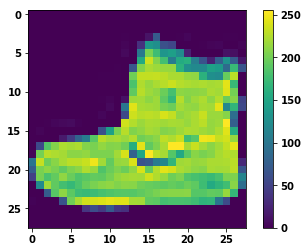

In [79]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255.

In [80]:
train_images = train_images / 255.0

test_images = test_images / 255.0

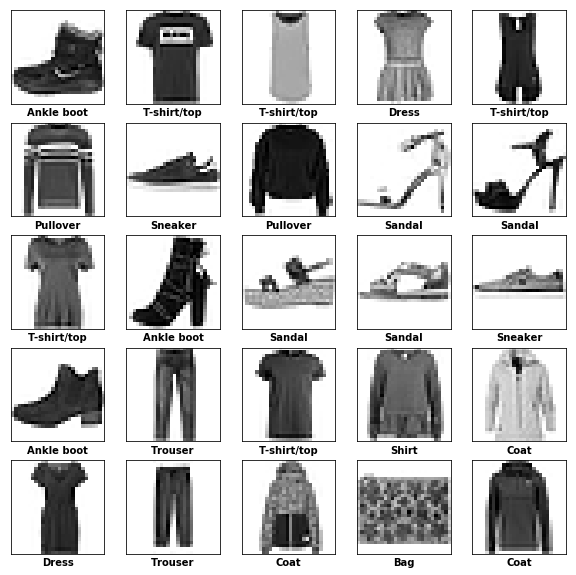

In [84]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

#### Build the model

In [85]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10)
])

The first layer in this network, tf.keras.layers.Flatten, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two tf.keras.layers.Dense layers. These are densely connected, or fully connected, neural layers. The first Dense layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

#### Compile the model

In [86]:
# Loss function : 损失函数
# Opitmizer: 优化器
# Metrics: 评估度量

In [87]:
model.compile(optimizer="adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

#### Train the model

Training the neural network model requires the following steps:

+ Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
+ The model learns to associate images and labels.
+ You ask the model to make predictions about a test set—in this example, the test_images array.
+ Verify that the predictions match the labels from the test_labels array.

In [88]:
model.fit(train_images, train_labels, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 50us/sample - loss: 0.4936 - accuracy: 0.8263
Epoch 2/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3762 - accuracy: 0.8632
Epoch 3/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.3351 - accuracy: 0.8774
Epoch 4/10
60000/60000 [==============================] - 3s 47us/sample - loss: 0.3147 - accuracy: 0.8843
Epoch 5/10
60000/60000 [==============================] - 3s 51us/sample - loss: 0.2961 - accuracy: 0.8914
Epoch 6/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2791 - accuracy: 0.8952
Epoch 7/10
60000/60000 [==============================] - 3s 46us/sample - loss: 0.2684 - accuracy: 0.9008
Epoch 8/10
60000/60000 [==============================] - 3s 49us/sample - loss: 0.2562 - accuracy: 0.9035
Epoch 9/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.2469 - accuracy: 0.9084
Epoch 10/10
60

#### Evaluate accuracy

In [91]:
test_los, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print("\nTest accuracy:", test_acc)

10000/10000 - 0s - loss: 0.3315 - accuracy: 0.8882

Test accuracy: 0.8882


In [92]:
# 测试集的准确度低于训练集，这差距代表着发生了过拟合

#### Make predictions

In [94]:
# 训练结束后，可以用模型对图片进行预测,模型的线性输出logits， 附上softmax层将logits转换为概率

In [93]:
probability_model = tf.keras.Sequential([model,
                                        tf.keras.layers.Softmax()])

In [95]:
predicitons = probability_model.predict(test_images)

In [96]:
predicitons[0]

array([6.2901357e-08, 1.9816373e-07, 2.0815552e-08, 3.7080403e-09,
       8.2418389e-08, 1.1873959e-01, 8.8290284e-07, 7.9043098e-02,
       1.3957368e-05, 8.0220211e-01], dtype=float32)

In [98]:
# 查看预测图片输出的最大值
np.argmax(predicitons[0])

9

In [99]:
# 查看labels对应图片种类
test_labels[0]

9

In [100]:
# 画图展示完成的10类预测

In [101]:
# plt.xlim、plt.ylim 设置横纵坐标轴范围
# plt.xlabel、plt.ylabel 设置坐标轴名称
# plt.xticks、plt.yticks设置坐标轴刻度

In [113]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = "blue"
    else:
        color = "red"
        
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                        100*np.max(predictions_array),
                                        class_names[true_label]),
                                        color=color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color("red")
    thisplot[true_label].set_color("blue")

#### Verify predictions

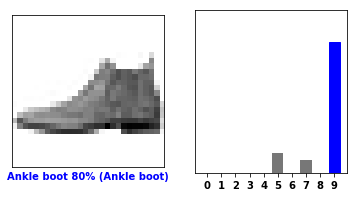

In [114]:
i = 0
plt.figure(figsize=(6 ,3))
plt.subplot(1,2,1)
plot_image(i ,predicitons[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predicitons[i], test_labels)
plt.show()

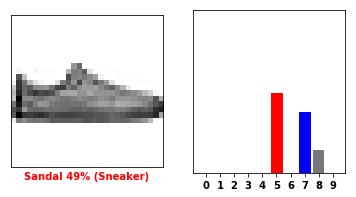

In [115]:
i = 12
plt.figure(figsize=(6 ,3))
plt.subplot(1,2,1)
plot_image(i ,predicitons[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predicitons[i], test_labels)
plt.show()

In [116]:
# plot多张图片

In [117]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

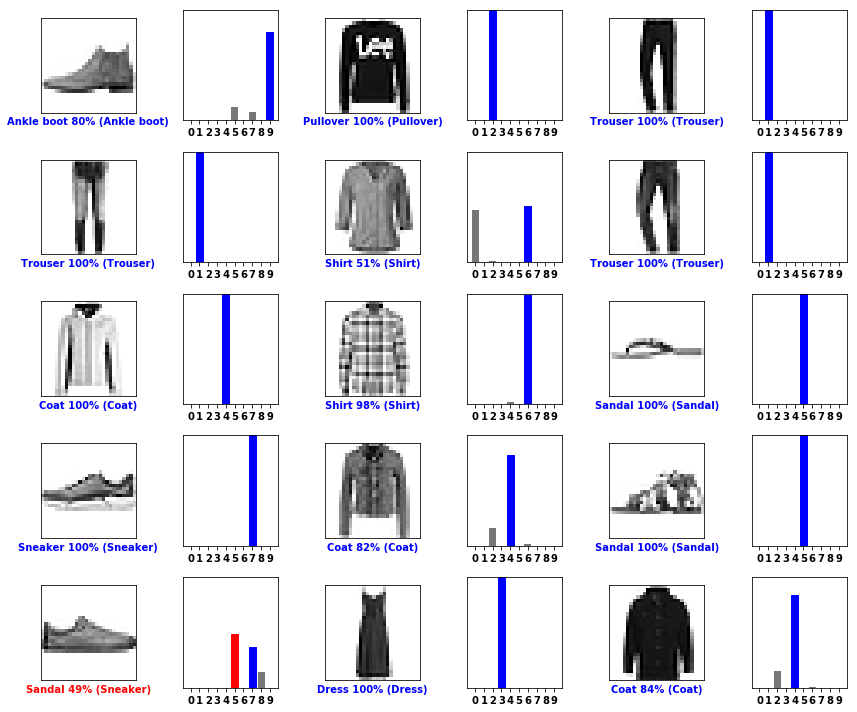

In [119]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2*i + 1)
    plot_image(i, predicitons[i], test_labels, test_images)
    plt.subplot(num_rows, 2 * num_cols, 2*i + 2)
    plot_value_array(i, predicitons[i], test_labels)
plt.tight_layout()
plt.show()

#### Use the trained model

In [121]:
# 用已经训练好的模型对单个图片进行预测

In [122]:
img = test_images[1]
print(img.shape)

(28, 28)


tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. Accordingly, even though you're using a single image

In [123]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img, 0))
print(img.shape)

(1, 28, 28)


In [125]:
predicitons_single = probability_model.predict(img)
print(predicitons_single)

[[4.6013656e-06 8.9204408e-17 9.9963713e-01 3.4472932e-13 3.1328952e-04
  4.3999977e-17 4.4929689e-05 8.5061373e-16 3.5990369e-14 5.8409613e-16]]


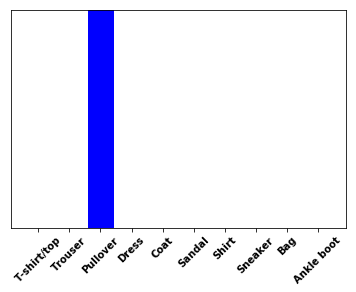

In [127]:
plot_value_array(1, predicitons_single[0], test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

keras.Model.predict returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [128]:
np.argmax(predicitons_single[0])

2

### 使用TF Hub进行文本分类

In [130]:
# tf.keras 用于构建和训练模型的高级API
# Tensorflow hub 用于迁移学习的库

使用 Keras 和 Tensorflow Hub 对电影评论进行文本分类

In [136]:
!pip install tensorflow_hub -i https://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [137]:
!pip install tensorflow_datasets -i https://mirrors.aliyun.com/pypi/simple/ --trusted-host mirrors.aliyun.com

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78598 sha256=f38f09a6f0f62104cb0015d6f953500e48b9aebf8f1459aaf568a12ca7ba43c4
  Stored in directory: c:\users\huangm\appdata\local\pip\cache\wheels\c7\48\83\b86babe2500d1fb31415af05737ada858946a6ba854ba58422
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21500 sha256=a5ca32b7cf43e57472985066db6d08fa4b800dd4f6b41c4e3d448fd20a566fff
  Stored in directory: c:\users\huangm\appdata\local\pip\cache\wheels\64\98\76\73cf1a99a8cef27fd68d1993f938de11cafdcbfe7c19eea123
Successfully built dill promise


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else " NOT AVAILABLE")

Version: 2.1.0
Eager mode: True
Hub version: 0.8.0
GPU is  NOT AVAILABLE


#### 下载IMDB数据集

In [2]:
# 将训练集按照 6:4 的比例进行切割，从而最终我们将得到 15,000
# 个训练样本, 10,000 个验证样本以及 25,000 个测试样本

# datasets split方法
# https://github.com/tensorflow/datasets/blob/master/docs/splits.md

# train_validation_split = tfds.Split.TRAIN.subsplit([6,4]) 
# 报错 AttributeError: 'Split' object has no attribute 'subsplit'
# 解决(换一种方法)：https://blog.csdn.net/kiva12138/article/details/104375000?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-3.nonecase&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-3.nonecase

(train_data, validation_data, test_data) = tfds.load(
    name="imdb_reviews",
    split=("train[:30%]", "train[30%:50%]", "test"),
    as_supervised=True
)

#### 探索数据

In [3]:
# 二分类 标签只有0或者1

train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'This is a big step down after the surprisingly enjoyable original. This sequel isn\'t nearly as fun as part one, and it instead spends too much time on plot development. Tim Thomerson is still the best thing about this series, but his wisecracking is toned down in this entry. The performances are all adequate, but this time the script lets us down. The action is merely routine and the plot is only mildly interesting, so I need lots of silly laughs in order to stay entertained during a "Trancers" movie. Unfortunately, the laughs are few and far between, and so, this film is watchable at best.',
       b"Perhaps because I was so young, innocent and BRAINWASHED when I saw it, this movie was the cause of many sleepless nights for me. I haven't seen it since I was in seventh grade at a Presbyterian school, so I am not sure what effect it would have on me now. However, I will say that it left an impression on me... and most of my friends

In [4]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int64)>

#### 构建模型

神经网络搭建:
+ 如何表示文本(embedding)
+ 模型多少层(layers)
+ 每层的隐藏单元数(hidden units)

这里使用预先训练好的文本嵌入作为首层    
使用 TensorFlow Hub 中名为 google/tf2-preview/gnews-swivel-20dim/1 的一种预训练文本嵌入（text embedding）模型 。

为了达到本教程的目的还有其他三种预训练模型可供测试：

+ google/tf2-preview/gnews-swivel-20dim-with-oov/1 ——类似 google/tf2-preview/gnews-swivel-20dim/1，但 2.5%的词汇转换为未登录词桶（OOV buckets）。如果任务的词汇与模型的词汇没有完全重叠，这将会有所帮助。
+ google/tf2-preview/nnlm-en-dim50/1 ——一个拥有约 1M 词汇量且维度为 50 的更大的模型。
+ google/tf2-preview/nnlm-en-dim128/1 ——拥有约 1M 词汇量且维度为128的更大的模型。

In [5]:
# 嵌入形状 (num_examples, embedding_dimension)

In [6]:
hub.__version__

'0.8.0'

In [ ]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

hub_layer = hub.KerasLayer(embedding, input_shape=[],output=[20],
                          dtype=tf.string, trainable=True)
hub_layer(train_examples_batch[:3])

In [8]:
# 网络问题，连接失败

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation="relu"))
mode.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.summary()

层按顺序堆叠以构建分类器：

+ 第一层是 Tensorflow Hub 层。这一层使用一个预训练的保存好的模型来将句子映射为嵌入向量（embedding vector）。我们所使用的预训练文本嵌入（embedding）模型(google/tf2-preview/gnews-swivel-20dim/1)将句子切割为符号，嵌入（embed）每个符号然后进行合并。最终得到的维度是：(num_examples, embedding_dimension)。
+ 该定长输出向量通过一个有 16 个隐层单元的全连接层（Dense）进行管道传输。
+ 最后一层与单个输出结点紧密相连。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信水平。

#### 损失函数与优化器

一个模型需要损失函数和优化器来进行训练。由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数。

这不是损失函数的唯一选择，例如，您可以选择 mean_squared_error 。但是，一般来说 binary_crossentropy 更适合处理概率——它能够度量概率分布之间的“距离”，或者在我们的示例中，指的是度量 ground-truth 分布与预测值之间的“距离”。

In [ ]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

#### 训练模型

以 512 个样本的 mini-batch 大小迭代 20 个 epoch 来训练模型。 这是指对 x_train 和 y_train 张量中所有样本的的 20 次迭代。在训练过程中，监测来自验证集的 10,000 个样本上的损失值（loss）和准确率（accuracy）：

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                   epochs=20,
                   validation_data=validation_data.batch(512),
                   verbose=1)

#### 评估模型

将返回两个值。损失值（loss）（一个表示误差的数字，值越低越好）与准确率（accuracy）。

In [ ]:
results = model.evaluate(test_data.batch(512),verbose=2)
for name, value in zip(model.metrics_names, result):
    print("%s: %.3f" % (name, value))

### 对预处理文本进行文本分类

电影评论分类

In [9]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.1.0


#### 下载IMDB数据集

In [10]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - ETA: 10:2 - ETA: 4:2 - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA:

参数 num_words=10000 保留了训练数据中最常出现的 10,000 个单词。为了保持数据规模的可管理性，低频词将被丢弃。

#### 探索数据

In [11]:
print("Training entries:{}, labels:{}".format(len(train_data), len(train_labels)))

Training entries:25000, labels:25000


In [12]:
# 评论文本被转化为整数值，每个整数代表词典中的一个单词
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [13]:
# 电影评论可能出现不同的长度，而神经网路的输入必须是统一的长度u，后续需要解决
len(train_data[0]), len(train_data[1])

(218, 189)

#### 将整数转换为单词

In [14]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()

# 保留第一个索引
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2 # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

1646592/1641221 [==============================] - ETA: 36 - ETA: 41 - ETA: 13 - ETA: 11 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 4us/step


In [15]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

#### 准备数据

影评——即整数数组必须在输入神经网络之前转换为张量。这种转换可以通过以下两种方式来完成：

+ 将数组转换为表示单词出现与否的由 0 和 1 组成的向量，类似于 one-hot 编码。例如，序列[3, 5]将转换为一个 10,000 维的向量，该向量除了索引为 3 和 5 的位置是 1 以外，其他都为 0。然后，将其作为网络的首层——一个可以处理浮点型向量数据的稠密层。不过，这种方法需要大量的内存，需要一个大小为 num_words * num_reviews 的矩阵。

+ 或者，我们可以填充数组来保证输入数据具有相同的长度，然后创建一个大小为 max_length * num_reviews 的整型张量。我们可以使用能够处理此形状数据的嵌入层作为网络中的第一层。

In [16]:
# 采用第二种方法

#使用pad_sequence函数来使长度标准化

In [19]:
train_data  = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding="post",
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                      value=word_index["<PAD>"],
                                                      padding="post",
                                                      maxlen=256)

In [20]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [22]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

#### 构建模型

神经网络由堆叠的层来构建，这需要从两个主要方面来进行体系结构决策：

+ 模型里有多少层？
+ 每个层里有多少隐层单元（hidden units）？

In [24]:
# keras Embedding： https://blog.csdn.net/songbinxu/article/details/80150019
# GlobalAveragePooling1D： https://blog.csdn.net/weixin_43824178/article/details/99182766

In [25]:
# 输入形状是用于电影评论的词汇数目(10000词)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


层按顺序堆叠以构建分类器：

+ 第一层是嵌入（Embedding）层。该层采用整数编码的词汇表，并查找每个词索引的嵌入向量（embedding vector）。这些向量是通过模型训练学习到的。向量向输出数组增加了一个维度。得到的维度为：(batch, sequence, embedding)。
+ 接下来，GlobalAveragePooling1D 将通过对序列维度求平均值来为每个样本返回一个定长输出向量。这允许模型以尽可能最简单的方式处理变长输入。
+ 该定长输出向量通过一个有 16 个隐层单元的全连接（Dense）层传输。
+ 最后一层与单个输出结点密集连接。使用 Sigmoid 激活函数，其函数值为介于 0 与 1 之间的浮点数，表示概率或置信度。

#### 损失函数和优化器

In [26]:
model.compile(optimizer="adam",
             loss="binary_crossentropy",
             metrics=["accuracy"])

#### 创建验证集

In [28]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### 训练模型

In [29]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - ETA: 33s - loss: 0.6936 - accuracy: 0.492 - ETA: 17s - loss: 0.6933 - accuracy: 0.510 - ETA: 8s - loss: 0.6931 - accuracy: 0.527 - ETA: 4s - loss: 0.6929 - accuracy: 0.53 - ETA: 2s - loss: 0.6927 - accuracy: 0.54 - ETA: 1s - loss: 0.6926 - accuracy: 0.53 - ETA: 1s - loss: 0.6925 - accuracy: 0.52 - ETA: 0s - loss: 0.6923 - accuracy: 0.54 - ETA: 0s - loss: 0.6922 - accuracy: 0.57 - ETA: 0s - loss: 0.6920 - accuracy: 0.58 - ETA: 0s - loss: 0.6918 - accuracy: 0.60 - 2s 130us/sample - loss: 0.6917 - accuracy: 0.6102 - val_loss: 0.6897 - val_accuracy: 0.7352
Epoch 2/40
15000/15000 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.74 - ETA: 0s - loss: 0.6891 - accuracy: 0.74 - ETA: 0s - loss: 0.6888 - accuracy: 0.74 - ETA: 0s - loss: 0.6885 - accuracy: 0.73 - ETA: 0s - loss: 0.6883 - accuracy: 0.72 - ETA: 0s - loss: 0.6880 - accuracy: 0.71 - ETA: 0s - loss: 0.6876 

Epoch 15/40
15000/15000 [==============================] - ETA: 0s - loss: 0.2840 - accuracy: 0.92 - ETA: 0s - loss: 0.2826 - accuracy: 0.90 - ETA: 0s - loss: 0.2772 - accuracy: 0.90 - ETA: 0s - loss: 0.2793 - accuracy: 0.90 - ETA: 0s - loss: 0.2766 - accuracy: 0.90 - ETA: 0s - loss: 0.2766 - accuracy: 0.90 - ETA: 0s - loss: 0.2775 - accuracy: 0.90 - ETA: 0s - loss: 0.2777 - accuracy: 0.90 - ETA: 0s - loss: 0.2777 - accuracy: 0.90 - ETA: 0s - loss: 0.2768 - accuracy: 0.90 - 1s 50us/sample - loss: 0.2757 - accuracy: 0.9059 - val_loss: 0.3262 - val_accuracy: 0.8738
Epoch 16/40
15000/15000 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.90 - ETA: 0s - loss: 0.2652 - accuracy: 0.90 - ETA: 0s - loss: 0.2684 - accuracy: 0.90 - ETA: 0s - loss: 0.2689 - accuracy: 0.90 - ETA: 0s - loss: 0.2704 - accuracy: 0.90 - ETA: 0s - loss: 0.2687 - accuracy: 0.90 - ETA: 0s - loss: 0.2664 - accuracy: 0.90 - ETA: 0s - loss: 0.2649 - accuracy: 0.90 - ETA: 0s - loss: 0.2635 - accuracy: 

#### 评估模型

In [31]:
# 评估模型的性能，返回两个值分别为loss和accuracy
results = model.evaluate(test_data, test_labels, verbose=2)
print(results)

25000/25000 - 1s - loss: 0.3315 - accuracy: 0.8723
[0.33147322151184083, 0.87228]


#### 创建一个准确率和损失值随时间变化的图表

model.fit() 返回一个 History 对象，该对象包含一个字典，其中包含训练阶段所发生的一切事件：

In [32]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

有四个条目：在训练和验证期间，每个条目对应一个监控指标。我们可以使用这些条目来绘制训练与验证过程的损失值（loss）和准确率（accuracy），以便进行比较。

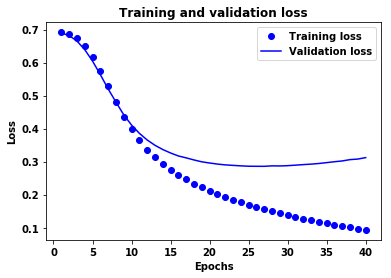

In [34]:
import matplotlib.pyplot as plt

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)

# "bo"代表 “蓝点”
plt.plot(epochs, loss, "bo", label="Training loss")
# b代表 “蓝色实线”
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

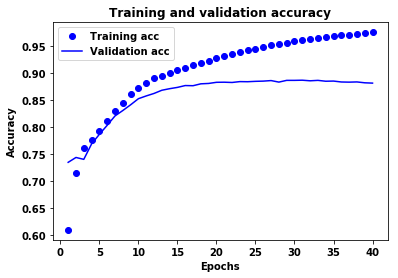

In [35]:
plt.clf() # 清除数字

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 回归

In [36]:
# 使用 seaborn 绘制矩阵图(pariplot)
!pip install -q seaborn

In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


Auto MPG数据集

#### 获取数据

In [41]:
# 下载数据
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] ETA:  - ETA:  - ETA:  - 5s 144us/step


'C:\\Users\\huangm\\.keras\\datasets\\auto-mpg.data'

In [43]:
# 使用pandas导入数据集
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### 数据清洗

In [47]:
# 查看NA值
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [48]:
# 删除NA值所在的行
dataset = dataset.dropna()

"Origin" 列实际上代表分类，而不仅仅是一个数字。所以把它转换为独热码 （one-hot）:

In [50]:
origin = dataset.pop("Origin")

In [56]:
# 查看种类
origin.value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

In [51]:
dataset["USA"] = (origin == 1) * 1.0
dataset["Europe"] = (origin == 2) * 1.0
dataset["Japan"] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


#### 拆分训练数据集和测试数据集

In [59]:
dataset.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            388, 389, 390, 391, 392, 393, 394, 395, 396, 397],
           dtype='int64', length=392)

In [60]:
# 拆分数据集，使用测试数据集对模型进行评估

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

数据检查

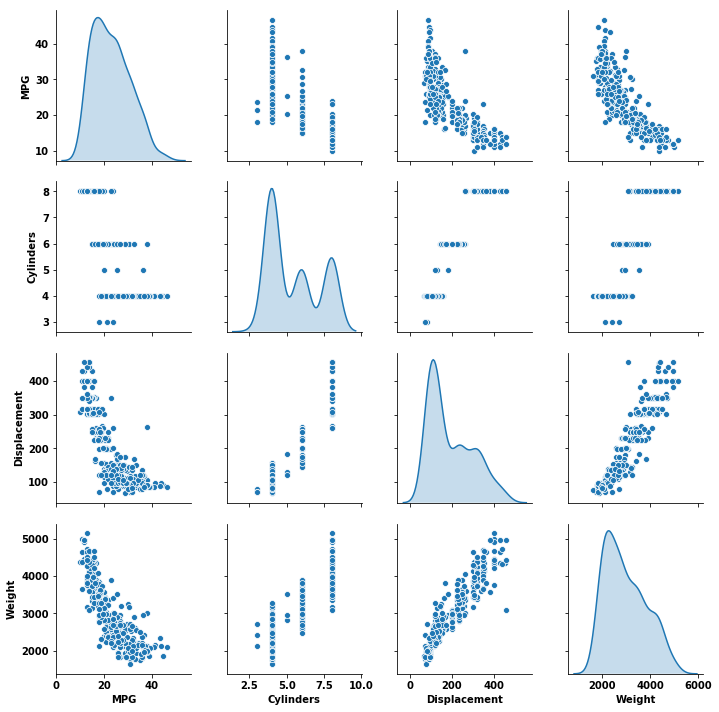

In [61]:
# 快速查看训练集中几对列的联合分布

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [64]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


从标签中分离特征

In [65]:
# 将特征值从目标值或者"标签"中分离。 这个标签是你使用训练模型进行预测的值。

train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

数据规范化

使用不同的尺度和范围对特征归一化是好的实践。尽管模型可能 在没有特征归一化的情况下收敛，它会使得模型训练更加复杂，并会造成生成的模型依赖输入所使用的单位选择。

注意：尽管我们仅仅从训练集中有意生成这些统计数据，但是这些统计信息也会用于归一化的测试数据集。我们需要这样做，将测试数据集放入到与已经训练过的模型相同的分布中。

In [67]:
def norm(x):
    """归一化"""
    return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [68]:
# 警告: 用于归一化输入的数据统计（均值和标准差）需要反馈给模型从而应用于任何其他数据

In [72]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

#### 构建模型

构建模型 ：    
我们将会使用一个“顺序”模型，其中包含两个紧密相连的隐藏层，以及返回单个、连续值得输出层

In [74]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mse",
                 optimizer=optimizer,
                 metrics=["mae", "mse"])
    return model

In [75]:
model = build_model()

检查模型：

In [76]:
# 使用.summay方法打印该模型的简单描述
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [77]:
# 使用
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.2267621 ],
       [ 0.1510026 ],
       [-0.02871213],
       [ 0.36990958],
       [ 0.82545185],
       [ 0.01788014],
       [ 0.85847306],
       [-0.00670937],
       [ 0.06877758],
       [ 0.5030005 ]], dtype=float32)

#### 训练模型

In [78]:
# 对模型进行1000个周期的训练，并在 history 对象中记录训练和验证的准确性。

In [79]:
# 通过为每个完成的时期打印一个点来显示训练进度
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print("")
        print(".", end="")
        
EPOCHS = 1000

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

使用 history 对象中存储的统计信息可视化模型的训练进度。

In [81]:
history.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

In [83]:
# history.epoch

In [84]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.087536,0.866963,2.087536,9.293577,2.278764,9.293577,995
996,1.979845,0.859931,1.979845,8.663844,2.268161,8.663843,996
997,2.185035,0.904075,2.185035,9.008751,2.325166,9.008751,997
998,2.424686,0.966130,2.424686,8.956639,2.227407,8.956640,998
999,2.215607,0.915260,2.215607,9.401766,2.237398,9.401767,999


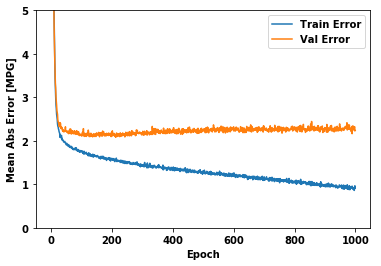

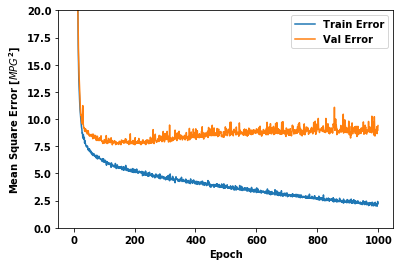

In [85]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist["epoch"] = history.epoch
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Abs Error [MPG]")
    plt.plot(hist["epoch"], hist["mae"],label="Train Error")
    plt.plot(hist["epoch"], hist["val_mae"], label="Val Error")
    
    plt.ylim([0, 5])
    plt.legend()
    
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Square Error [$MPG^2$]")
    plt.plot(hist["epoch"], hist["mse"], label="Train Error")
    plt.plot(hist["epoch"], hist["val_mse"], label="Val Error")
    
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

该图表显示在约100个 epochs 之后误差非但没有改进，反而出现恶化。 让我们更新 model.fit 调用，当验证值没有提高上是自动停止训练。 我们将使用一个 EarlyStopping callback 来测试每个 epoch 的训练条件。如果经过一定数量的 epochs 后没有改进，则自动停止训练。


............................................................................

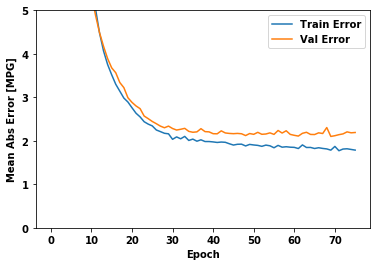

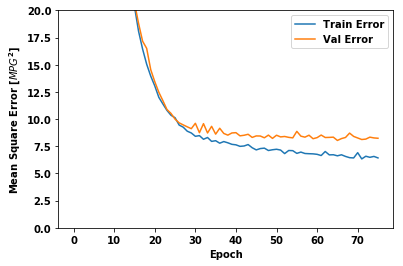

In [86]:
model = build_model()

# patience 值用来检查改进 epochs的数量
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [87]:
# 如图所示，验证集中的平均的误差通常在 +/- 2 MPG左右。 这个结果好么？ 我们将决定权留给你。

让我们看看通过使用 测试集 来泛化模型的效果如何，我们在训练模型时没有使用测试集

In [88]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing  set Meas Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 5.6642 - mae: 1.8731 - mse: 5.6642
Testing  set Meas Abs Error:  1.87 MPG


#### 预测

使用测试集的数据预测MPG值

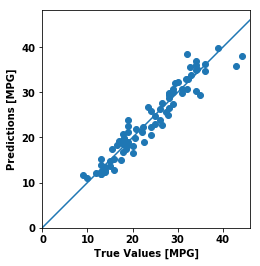

In [90]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis("equal")
plt.axis("square")
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

这看起来我们的模型预测得相当好。我们来看下误差分布。

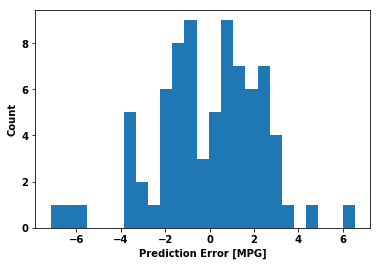

In [91]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

它不是完全的高斯分布，但我们可以推断出，这是因为样本的数量很小所导致的。

#### 结论

+ 均方误差（MSE）是用于回归问题的常见损失函数（分类问题中使用不同的损失函数）
+ 类似的，用于回归的评估指标与分类不同。 常见的回归指标是平均绝对误差（MAE）
+ 当数字输入数据特征的值存在不同范围时，每个特征应独立缩放到相同范围
+ 如果训练数据不多，一种方法是选择隐藏层较少的小网络，以避免过度拟合
+ 早期停止是一种防止过度拟合的有效技术

### 过拟合和欠拟合

#### Setup

In [3]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.1.0


In [3]:
!pip install -q git+https://github.com/tensorflow/docs

  ERROR: Error [WinError 2] 系统找不到指定的文件。 while executing command git clone -q https://github.com/tensorflow/docs 'C:\Users\huangm\AppData\Local\Temp\pip-req-build-g4uz2z5u'
ERROR: Cannot find command 'git' - do you have 'git' installed and in your PATH?


In [4]:
#### 报错待定中

### 保存和加载

模型可以在训练期间和训练完成后进行保存。这意味着模型可以从任意中断中恢复，并避免耗费比较长的时间在训练上。保存也意味着您可以共享您的模型，而其他人可以通过您的模型来重新创建工作。在发布研究模型和技术时，大多数机器学习从业者分享：
+ 用于创建模型的代码
+ 模型训练的权重 (weight) 和参数 (parameters) 。

#### 配置

In [4]:
# 安装并导入

# 需要以HDF5 格式保存模型
!pip install -q pyyaml h5py 

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.1.0


#### 获取示例数据集

In [8]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28*28) / 255.0
test_images = test_images[:1000].reshape(-1, 28*28) / 255.0

#### 定义模型

In [9]:
# 构建简单的序列模型

def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation="relu", input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])
    return model

# 创建一个基本的模型实例
model = create_model()

# 显示模型的结构
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


#### 在训练期间保存模型(以checkponits形式保存)

您可以使用训练好的模型而无需从头开始重新训练，或在您打断的地方开始训练，以防止训练过程没有保存。 tf.keras.callbacks.ModelCheckpoint 允许在训练的过程中和结束时回调保存的模型。

Checkpoint回调用法

创建一个只在训练期间保存权重的 tf.keras.callbacks.ModelCheckpoint 回调：

In [10]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个保存模型权重的回调
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                save_weights_only = True,
                                                verbose=1)

# 使用新的回调训练模型
model.fit(train_images,
          train_labels,
         epochs=10,
         validation_data=(test_images, test_labels),
         callbacks=[cp_callback]) # 通过回调训练

# 这可能会生成与保存优化程序状态相关的警告
# 这些警告(以及整个笔记本中的类似警告)是防止过时使用，可以忽略

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
 864/1000 [========================>.....] - ETA: 0s - loss: 1.2893 - accuracy: 0.6273
Epoch 00001: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 1s 650us/sample - loss: 1.1812 - accuracy: 0.6630 - val_loss: 0.7196 - val_accuracy: 0.7790
Epoch 2/10
 704/1000 [====================>.........] - ETA: 0s - loss: 0.4472 - accuracy: 0.8622
Epoch 00002: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 0s 391us/sample - loss: 0.4324 - accuracy: 0.8750 - val_loss: 0.5374 - val_accuracy: 0.8160
Epoch 3/10
 992/1000 [============================>.] - ETA: 0s - loss: 0.3007 - accuracy: 0.9244
Epoch 00003: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 0s 406us/sample - loss: 0.3003 - accuracy: 0.9240 - val_loss: 0.4862 - val_accuracy: 0.8340
Epoch 4/10
 768/1000 [======================>.......] - ETA: 0s - loss: 0.2333 - accuracy: 0.9401
Epoch

这将创建一个 TensorFlow checkpoint 文件集合，这些文件在每个 epoch 结束时更新：

In [2]:
pwd

'G:\\桌面'

In [13]:
# ls {checkpoint_dir}

创建一个新的未经训练的模型。仅恢复模型的权重时，必须具有与原始模型具有相同网络结构的模型。由于模型具有相同的结构，您可以共享权重，尽管它是模型的不同实例。 现在重建一个新的未经训练的模型，并在测试集上进行评估。未经训练的模型将在机会水平（chance levels）上执行（准确度约为10％）：

In [14]:
# 闯将一个基本实例
model = create_model()

# 评估模型
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrain model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 2.3888 - accuracy: 0.1040
Untrain model, accuracy: 10.40%


然后从checkpoint加载权重并重新评估

In [15]:
# 加载权重
model.load_weights(checkpoint_path)

# 重新评估模型
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 0.4172 - accuracy: 0.8710
Restored model, accuracy: 87.10%


checkpoint回调选项

回调提供了几个选项，为 checkpoint 提供唯一名称并调整 checkpoint 频率。

训练一个新模型，每五个 epochs 保存一次唯一命名的 checkpoint ：

In [17]:
# 在文件中包含epoch (使用"str.format')
checkpoint_path = "train_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 创建一个回调，每5个epochs保存模型的权重
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    period=5
)

# 创建一个新的模型实例
model = create_model()

# 使用“checkpoint_path”格式保存权重
model.save_weights(checkpoint_path.format(epoch=0))

# 使用新的回调*训练*模型
model.fit(train_images,
         train_labels,
         epochs=50,
         callbacks=[cp_callback],
         validation_data=(test_images, test_labels),
         verbose=0)

W0614 03:47:33.162125  2128 callbacks.py:886] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.



Epoch 00005: saving model to train_2/cp-0005.ckpt

Epoch 00010: saving model to train_2/cp-0010.ckpt

Epoch 00015: saving model to train_2/cp-0015.ckpt

Epoch 00020: saving model to train_2/cp-0020.ckpt

Epoch 00025: saving model to train_2/cp-0025.ckpt

Epoch 00030: saving model to train_2/cp-0030.ckpt

Epoch 00035: saving model to train_2/cp-0035.ckpt

Epoch 00040: saving model to train_2/cp-0040.ckpt

Epoch 00045: saving model to train_2/cp-0045.ckpt

Epoch 00050: saving model to train_2/cp-0050.ckpt


现在查看生成的 checkpoint 并选择最新的 checkpoint ：

In [20]:
# ls {checkpoint_dir}

In [21]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'train_2\\cp-0050.ckpt'

注意: 默认的 tensorflow 格式仅保存最近的5个 checkpoint 。

如果要进行测试，请重置模型并加载最新的 checkpoint ：

In [23]:
# 创建一个新的实例
model = create_model()

# 加载以前保存的权重
model.load_weights(latest)

# 重新评估模型
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 0.4847 - accuracy: 0.8810
Restored model, accuracy: 88.10%


这些文件是什么？

上述代码将权重存储到 checkpoint—— 格式化文件的集合中，这些文件仅包含二进制格式的训练权重。 Checkpoints 包含：

一个或多个包含模型权重的分片。
索引文件，指示哪些权重存储在哪个分片中。
如果你只在一台机器上训练一个模型，你将有一个带有后缀的碎片： .data-00000-of-00001

#### 手动保存权重

您将了解如何将权重加载到模型中。使用 Model.save_weights 方法手动保存它们同样简单。默认情况下， tf.keras 和 save_weights 特别使用 TensorFlow checkpoints 格式 .ckpt 扩展名和 ( 保存在 HDF5 扩展名为 .h5 保存并序列化模型 )：

In [25]:
# 保存权重
model.save_weights("./checkpoints/my_checkpoint")

# 创建模型实例
model = create_model()

# Restore the weights
model.load_weights("./checkpoints/my_checkpoint")

# Evaluate the model
loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restore model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 2.2909 - accuracy: 0.1510
Restore model, accuracy: 15.10%


#### 保存整个模型

模型和优化器可以保存到包含其状态（权重和变量）和模型参数的文件中。这可以让您导出模型，以便在不访问原始 python 代码的情况下使用它。而且您可以通过恢复优化器状态的方式，从中断的位置恢复训练。

保存完整模型会非常有用——您可以在 TensorFlow.js (HDF5, Saved Model) 加载他们，然后在 web 浏览器中训练和运行它们，或者使用 TensorFlow Lite 将它们转换为在移动设备上运行(HDF5, Saved Model)

In [26]:
# 将模型保存为HDF5文件

Keras 可以使用 HDF5 标准提供基本保存格式。出于我们的目的，可以将保存的模型视为单个二进制blob：

In [28]:
# 创建一个新的模型实例
model = create_model()

# 训练模型
model.fit(train_images, train_labels, epochs=5)

# 将整个模型保存为HDF5文件
model.save("my_model.h5")

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 319us/sample - loss: 1.1263 - accuracy: 0.6880
Epoch 2/5
1000/1000 [==============================] - 0s 136us/sample - loss: 0.4332 - accuracy: 0.8830
Epoch 3/5
1000/1000 [==============================] - 0s 165us/sample - loss: 0.2757 - accuracy: 0.9190
Epoch 4/5
1000/1000 [==============================] - 0s 137us/sample - loss: 0.2108 - accuracy: 0.9460
Epoch 5/5
1000/1000 [==============================] - 0s 147us/sample - loss: 0.1563 - accuracy: 0.9660


现在，从该文件重新创建模型:

In [29]:
# 重新创建相同的模型，包括其权重和优化程序
new_model = keras.models.load_model("my_model.h5")

# 显示网络结构
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


检查其准确率：

In [30]:
loss, acc  = new_model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 0.4331 - accuracy: 0.8650
Restored model, accuracy: 86.50%


这项技术可以保存一切:
+ 权重
+ 模型配置(结构)
+ 优化器配置

Keras 通过检查网络结构来保存模型。目前，它无法保存 Tensorflow 优化器（调用自 tf.train）。使用这些的时候，您需要在加载后重新编译模型，否则您将失去优化器的状态。

In [31]:
# 通过saved_model保存

注意：这种保存 tf.keras 模型的方法是实验性的，在将来的版本中可能有所改变。

In [33]:
model = create_model()
model.fit(train_images, train_labels, epochs=5)

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 331us/sample - loss: 1.1494 - accuracy: 0.6700
Epoch 2/5
1000/1000 [==============================] - 0s 132us/sample - loss: 0.4198 - accuracy: 0.8850
Epoch 3/5
1000/1000 [==============================] - 0s 131us/sample - loss: 0.2758 - accuracy: 0.9260
Epoch 4/5
1000/1000 [==============================] - 0s 157us/sample - loss: 0.1904 - accuracy: 0.9590
Epoch 5/5
1000/1000 [==============================] - 0s 136us/sample - loss: 0.1426 - accuracy: 0.9740


创建一个 saved_model，并将其放在带有 tf.keras.experimental.export_saved_model 的带时间戳的目录中

In [34]:
import time
saved_model_path = "./saved_models/{}".format(int(time.time()))

tf.keras.experimental.export_saved_model(model, saved_model_path)
saved_model_path

AttributeError: module 'tensorflow_core.keras.experimental' has no attribute 'export_saved_model'

从保存的模型重新加载新的 Keras 模型：

In [ ]:
new_model = tf.keras.experimental.load_from_saved_model(saved_model_path)

# 显示网络结构
new_model.summary()

## 加载和与预处理数据

#### CSV

In [35]:
# 用tf.data 加载CSV数据
# 怎样将 CSV 格式的数据加载进 tf.data.Dataset

In [28]:
from  __future__ import absolute_import, division, print_function, unicode_literals
import functools

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

① 设置

In [2]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("test.csv", TEST_DATA_URL)

In [3]:
# 让 Numpy 数据更易读
np.set_printoptions(precision=3, suppress=True)

② 加载数据

In [4]:
# !head {train_file_path}

# window10问题？

正如你看到的那样，CSV 文件的每列都会有一个列名。dataset 的构造函数会自动识别这些列名。如果你使用的文件的第一行不包含列名，那么需要将列名通过字符串列表传给 make_csv_dataset 函数的 column_names 参数。

In [5]:
# CSV_COLUMNS = ['survived', 'sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

# dataset = tf.data.experimental.make_csv_dataset(
#     ...,
#     column_names=CSV_COLUMNS,
#     ...
# )

这个示例使用了所有的列。如果你需要忽略数据集中的某些列，创建一个包含你需要使用的列的列表，然后传给构造器的（可选）参数 select_columns。

In [6]:
# dataset = tf.data.experimental.make_csv_dataset(
#   ...,
#   select_columns = columns_to_use, 
#   ...)

对于包含模型需要预测的值的列是你需要显式指定的。

In [7]:
LABEL_COLUMN = 'survived'
LABELS = [0, 1]

现在从文件中读取 CSV 数据并且创建 dataset

In [8]:
def get_dataset(file_path):
    dataset = tf.data.experimental.make_csv_dataset(
    file_path,
    batch_size = 12, #为了示例更容易展示，手动设置较小的值
    label_name = LABEL_COLUMN,
    na_value = "?",
    num_epochs = 1,
    ignore_errors = True
    )
    return dataset

raw_train_data = get_dataset(train_file_path)
raw_test_data = get_dataset(test_file_path)

dataset 中的每个条目都是一个批次，用一个元组（多个样本，多个标签）表示。样本中的数据组织形式是以列为主的张量（而不是以行为主的张量），每条数据中包含的元素个数就是批次大小（这个示例中是 12）。

In [9]:
examples, labels = next(iter(raw_train_data)) # 第一个批次
print("EXAMPLES: \n", examples, "\n")
print("LABLES: \n", labels)
print(len(examples))

EXAMPLES: 
 OrderedDict([('sex', <tf.Tensor: shape=(12,), dtype=string, numpy=
array([b'female', b'female', b'male', b'male', b'male', b'male',
       b'female', b'male', b'male', b'male', b'female', b'male'],
      dtype=object)>), ('age', <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([28. , 32.5, 35. , 21. , 37. , 62. , 31. ,  1. , 28.5, 28. , 48. ,
       28. ], dtype=float32)>), ('n_siblings_spouses', <tf.Tensor: shape=(12,), dtype=int32, numpy=array([1, 0, 0, 0, 1, 0, 0, 4, 0, 0, 1, 1])>), ('parch', <tf.Tensor: shape=(12,), dtype=int32, numpy=array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0])>), ('fare', <tf.Tensor: shape=(12,), dtype=float32, numpy=
array([51.862, 13.   ,  7.896,  8.05 , 26.   , 10.5  ,  8.683, 39.688,
        7.229, 52.   , 65.   , 19.967], dtype=float32)>), ('class', <tf.Tensor: shape=(12,), dtype=string, numpy=
array([b'First', b'Second', b'Third', b'Third', b'Second', b'Second',
       b'Third', b'Third', b'Third', b'First', b'Second', b'Third'],
      dtype=

③ 数据预处理

In [10]:
# 1. 分类数据

CSV 数据中的有些列是分类的列。也就是说，这些列只能在有限的集合中取值。

使用 tf.feature_column API 创建一个 tf.feature_column.indicator_column 集合，每个 tf.feature_column.indicator_column 对应一个分类的列。

In [11]:
CATEGORIES = {
    "sex": ["male", "female"],
    "class": ["First", "Second", "Third"],
    "deck": ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"],
    "embark_town": ['Cherbourg', 'Southhampton', 'Queenstown'],
    "alone": ["y", "n"]
}

In [12]:
categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = tf.feature_column.categorical_column_with_vocabulary_list(
            key=feature, vocabulary_list=vocab)
    categorical_columns.append(tf.feature_column.indicator_column(cat_col))

In [13]:
# 刚才创建的内容
categorical_columns

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('First', 'Second', 'Third'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Cherbourg', 'Southhampton', 'Queenstown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)),
 IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='alone', vocabulary_list=('y', 'n'), dtype=tf.string, default_value=-1, num_oov_buckets=0))]

In [14]:
# 2.连续数据

连续数据需要标准化。

写一个函数标准化这些值，然后将这些值改造成 2 维的张量。

In [15]:
def process_continuous_data(mean, data):
    # 标准化数据
    data = tf.cast(data, tf.float32) * 1 /(2*mean)
    return tf.reshape(data, [-1, 1])

现在创建一个数值列的集合。tf.feature_columns.numeric_column API 会使用 normalizer_fn 参数。在传参的时候使用 functools.partial，functools.partial 由使用每个列的均值进行标准化的函数构成。

In [16]:
MEANS = {
    'age' : 29.631308,
    'n_siblings_spouses' : 0.545455,
    'parch' : 0.379585,
    'fare' : 34.385399
}

numerical_columns = []

for feature in MEANS.keys():
    num_col = tf.feature_column.numeric_column(feature, normalizer_fn=functools.partial(process_continuous_data, MEANS[feature]))
    numerical_columns.append(num_col)

In [17]:
# 刚才创建的内容
numerical_columns

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x00000214B0E0AD08>, 29.631308)),
 NumericColumn(key='n_siblings_spouses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x00000214B0E0AD08>, 0.545455)),
 NumericColumn(key='parch', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x00000214B0E0AD08>, 0.379585)),
 NumericColumn(key='fare', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=functools.partial(<function process_continuous_data at 0x00000214B0E0AD08>, 34.385399))]

这里使用标准化的方法需要提前知道每列的均值。如果需要计算连续的数据流的标准化的值可以使用 TensorFlow Transform。

In [18]:
# 创建预处理层

将这两个特征列的集合相加，并且传给 tf.keras.layers.DenseFeatures 从而创建一个进行预处理的输入层。

In [19]:
preprocessing_layer = tf.keras.layers.DenseFeatures(categorical_columns+numerical_columns)

④ 构建模型

从 preprocessing_layer 开始构建 tf.keras.Sequential。

In [20]:
model = tf.keras.Sequential([
    preprocessing_layer,
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

⑤ 训练，评估和预测

In [21]:
train_data = raw_train_data.shuffle(500)
test_data = raw_test_data

In [22]:
model.fit(train_data, epochs=20)

W0616 02:19:15.159461  2336 deprecation.py:323] From F:\Anaconda3\lib\site-packages\tensorflow_core\python\feature_column\feature_column_v2.py:4267: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0616 02:19:15.160964  2336 deprecation.py:323] From F:\Anaconda3\lib\site-packages\tensorflow_core\python\feature_column\feature_column_v2.py:4322: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


Epoch 1/20
53/53 [==============================]: 0.5998 - accuracy: 0.833 - 1s 259ms/step - loss: 0.6811 - accuracy: 0.666 - 1s 174ms/step - loss: 0.6329 - accuracy: 0.722 - 1s 132ms/step - loss: 0.6426 - accuracy: 0.687 - 1s 107ms/step - loss: 0.6770 - accuracy: 0.650 - 1s 90ms/step - loss: 0.6552 - accuracy: 0.666 - 1s 78ms/step - loss: 0.6354 - accuracy: 0.67 - 1s 69ms/step - loss: 0.6218 - accuracy: 0.68 - 1s 62ms/step - loss: 0.6298 - accuracy: 0.66 - 1s 56ms/step - loss: 0.6310 - accuracy: 0.65 - 1s 52ms/step - loss: 0.6243 - accuracy: 0.66 - 1s 48ms/step - loss: 0.6188 - accuracy: 0.67 - 1s 45ms/step - loss: 0.6201 - accuracy: 0.67 - 1s 42ms/step - loss: 0.6165 - accuracy: 0.67 - 1s 40ms/step - loss: 0.6073 - accuracy: 0.68 - 1s 38ms/step - loss: 0.6038 - accuracy: 0.69 - 1s 36ms/step - loss: 0.6007 - accuracy: 0.69 - 1s 34ms/step - loss: 0.5982 - accuracy: 0.68 - 1s 33ms/step - loss: 0.5993 - accuracy: 0.69 - 1s 31ms/step - loss: 0.5951 - accuracy: 0.70 - 1s 30ms/step - loss:

当模型训练完成的时候，你可以在测试集 test_data 上检查准确性。

In [25]:
test_loss, test_accuracy = model.evaluate(test_data)

print("\n\nTest Loss {}, Test Accuracy {}".format(test_loss, test_accuracy))

     22/Unknown - 0s 7ms/step - loss: 0.3222 - accuracy: 0.916 - 0s 6ms/step - loss: 0.3065 - accuracy: 0.916 - 0s 6ms/step - loss: 0.3808 - accuracy: 0.861 - 0s 5ms/step - loss: 0.3967 - accuracy: 0.875 - 0s 5ms/step - loss: 0.4072 - accuracy: 0.866 - 0s 5ms/step - loss: 0.4839 - accuracy: 0.819 - 0s 5ms/step - loss: 0.4672 - accuracy: 0.821 - 0s 5ms/step - loss: 0.4703 - accuracy: 0.822 - 0s 5ms/step - loss: 0.4770 - accuracy: 0.824 - 0s 5ms/step - loss: 0.4837 - accuracy: 0.825 - 0s 5ms/step - loss: 0.4890 - accuracy: 0.818 - 0s 5ms/step - loss: 0.4739 - accuracy: 0.826 - 0s 5ms/step - loss: 0.4599 - accuracy: 0.833 - 0s 5ms/step - loss: 0.4589 - accuracy: 0.833 - 0s 5ms/step - loss: 0.4444 - accuracy: 0.838 - 0s 5ms/step - loss: 0.4835 - accuracy: 0.817 - 0s 5ms/step - loss: 0.4648 - accuracy: 0.828 - 0s 5ms/step - loss: 0.4569 - accuracy: 0.828 - 0s 5ms/step - loss: 0.4564 - accuracy: 0.828 - 0s 5ms/step - loss: 0.4527 - accuracy: 0.825 - 0s 5ms/step - loss: 0.4506 - accuracy: 0.8

使用 tf.keras.Model.predict 推断一个批次或多个批次的标签。

In [26]:
predictions = model.predict(test_data)

# 显示部分结果
for prediction, survived in zip(predictions[:10], list(test_data)[0][1][:10]):
    print("Predicted survival: {:.2%}".format(prediction[0]),
         "| Actual outcome:",
         ("SURVIVED" if bool(survived) else "DIED"))

Predicted survival: 26.53% | Actual outcome: DIED
Predicted survival: 53.32% | Actual outcome: SURVIVED
Predicted survival: 38.34% | Actual outcome: SURVIVED
Predicted survival: 36.70% | Actual outcome: DIED
Predicted survival: 11.13% | Actual outcome: DIED
Predicted survival: 66.93% | Actual outcome: DIED
Predicted survival: 14.21% | Actual outcome: DIED
Predicted survival: 89.74% | Actual outcome: DIED
Predicted survival: 84.84% | Actual outcome: DIED
Predicted survival: 9.96% | Actual outcome: SURVIVED


#### Numpy

In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

从.npz文件中加载

In [40]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'

path = tf.keras.utils.get_file("mnist.npz", DATA_URL)
with np.load(path) as data:
    train_examples = data["x_train"]
    train_labels = data["y_train"]
    test_examples = data["x_test"]
    test_labels = data["y_test"]

使用 tf.data.Dataset 加载 NumPy 数组

假设您有一个示例数组和相应的标签数组，请将两个数组作为元组传递给 tf.data.Dataset.from_tensor_slices 以创建 tf.data.Dataset 。

In [41]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

使用该数据集

In [42]:
# 打乱和批次化数据集

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [43]:
# 建立和训练模型

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

In [44]:
model.fit(train_dataset, epochs=10)

Train for 938 steps
Epoch 1/10
938/938 [==============================] - ETA: 9:33 - loss: 227.8680 - sparse_categorical_accuracy: 0.156 - ETA: 40s - loss: 50.5942 - sparse_categorical_accuracy: 0.4865  - ETA: 20s - loss: 31.4439 - sparse_categorical_accuracy: 0.601 - ETA: 15s - loss: 25.1255 - sparse_categorical_accuracy: 0.656 - ETA: 12s - loss: 20.9509 - sparse_categorical_accuracy: 0.696 - ETA: 10s - loss: 18.2679 - sparse_categorical_accuracy: 0.725 - ETA: 8s - loss: 16.2803 - sparse_categorical_accuracy: 0.746 - ETA: 8s - loss: 15.2819 - sparse_categorical_accuracy: 0.75 - ETA: 7s - loss: 14.2477 - sparse_categorical_accuracy: 0.76 - ETA: 6s - loss: 13.2043 - sparse_categorical_accuracy: 0.77 - ETA: 6s - loss: 12.5764 - sparse_categorical_accuracy: 0.78 - ETA: 6s - loss: 11.9848 - sparse_categorical_accuracy: 0.78 - ETA: 5s - loss: 11.2593 - sparse_categorical_accuracy: 0.79 - ETA: 5s - loss: 10.6967 - sparse_categorical_accuracy: 0.80 - ETA: 5s - loss: 10.3403 - sparse_categori

938/938 [==============================] - ETA: 43s - loss: 0.4181 - sparse_categorical_accuracy: 0.93 - ETA: 5s - loss: 0.5333 - sparse_categorical_accuracy: 0.9449 - ETA: 3s - loss: 0.4854 - sparse_categorical_accuracy: 0.943 - ETA: 4s - loss: 0.4668 - sparse_categorical_accuracy: 0.944 - ETA: 4s - loss: 0.4672 - sparse_categorical_accuracy: 0.946 - ETA: 4s - loss: 0.4452 - sparse_categorical_accuracy: 0.946 - ETA: 4s - loss: 0.4387 - sparse_categorical_accuracy: 0.944 - ETA: 3s - loss: 0.4367 - sparse_categorical_accuracy: 0.945 - ETA: 3s - loss: 0.4122 - sparse_categorical_accuracy: 0.946 - ETA: 3s - loss: 0.4250 - sparse_categorical_accuracy: 0.944 - ETA: 3s - loss: 0.4484 - sparse_categorical_accuracy: 0.941 - ETA: 3s - loss: 0.4410 - sparse_categorical_accuracy: 0.941 - ETA: 3s - loss: 0.4290 - sparse_categorical_accuracy: 0.941 - ETA: 2s - loss: 0.4272 - sparse_categorical_accuracy: 0.940 - ETA: 2s - loss: 0.4280 - sparse_categorical_accuracy: 0.939 - ETA: 2s - loss: 0.4291 - s

938/938 [==============================] - ETA: 35s - loss: 0.2221 - sparse_categorical_accuracy: 0.93 - ETA: 5s - loss: 0.3253 - sparse_categorical_accuracy: 0.9639 - ETA: 3s - loss: 0.3348 - sparse_categorical_accuracy: 0.958 - ETA: 3s - loss: 0.2934 - sparse_categorical_accuracy: 0.960 - ETA: 3s - loss: 0.2559 - sparse_categorical_accuracy: 0.964 - ETA: 3s - loss: 0.2603 - sparse_categorical_accuracy: 0.963 - ETA: 2s - loss: 0.2629 - sparse_categorical_accuracy: 0.964 - ETA: 2s - loss: 0.2647 - sparse_categorical_accuracy: 0.963 - ETA: 2s - loss: 0.2668 - sparse_categorical_accuracy: 0.963 - ETA: 2s - loss: 0.2964 - sparse_categorical_accuracy: 0.961 - ETA: 2s - loss: 0.2870 - sparse_categorical_accuracy: 0.960 - ETA: 2s - loss: 0.2720 - sparse_categorical_accuracy: 0.962 - ETA: 2s - loss: 0.2856 - sparse_categorical_accuracy: 0.960 - ETA: 2s - loss: 0.2815 - sparse_categorical_accuracy: 0.960 - ETA: 2s - loss: 0.2799 - sparse_categorical_accuracy: 0.960 - ETA: 2s - loss: 0.2771 - s

938/938 [==============================] - ETA: 25s - loss: 0.5123 - sparse_categorical_accuracy: 0.98 - ETA: 3s - loss: 0.3156 - sparse_categorical_accuracy: 0.9737 - ETA: 3s - loss: 0.2583 - sparse_categorical_accuracy: 0.973 - ETA: 2s - loss: 0.2755 - sparse_categorical_accuracy: 0.974 - ETA: 2s - loss: 0.2472 - sparse_categorical_accuracy: 0.974 - ETA: 2s - loss: 0.2279 - sparse_categorical_accuracy: 0.974 - ETA: 2s - loss: 0.2409 - sparse_categorical_accuracy: 0.974 - ETA: 2s - loss: 0.2401 - sparse_categorical_accuracy: 0.973 - ETA: 2s - loss: 0.2431 - sparse_categorical_accuracy: 0.972 - ETA: 2s - loss: 0.2313 - sparse_categorical_accuracy: 0.973 - ETA: 2s - loss: 0.2265 - sparse_categorical_accuracy: 0.973 - ETA: 2s - loss: 0.2302 - sparse_categorical_accuracy: 0.973 - ETA: 2s - loss: 0.2254 - sparse_categorical_accuracy: 0.973 - ETA: 2s - loss: 0.2287 - sparse_categorical_accuracy: 0.972 - ETA: 2s - loss: 0.2315 - sparse_categorical_accuracy: 0.972 - ETA: 1s - loss: 0.2264 - s

In [46]:
model.evaluate(test_dataset)

157/157 [==============================] - ETA: 11s - loss: 0.3044 - sparse_categorical_accuracy: 0.98 - ETA: 0s - loss: 0.8195 - sparse_categorical_accuracy: 0.9430 - ETA: 0s - loss: 0.9205 - sparse_categorical_accuracy: 0.943 - ETA: 0s - loss: 0.8192 - sparse_categorical_accuracy: 0.948 - ETA: 0s - loss: 0.6543 - sparse_categorical_accuracy: 0.957 - 0s 2ms/step - loss: 0.6195 - sparse_categorical_accuracy: 0.9595


[0.6194935008026868, 0.9595]

#### pandas.DataFrame

将 pandas dataframes 加载到 tf.data.Dataset

① 使用pandas读取数据

In [54]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf

In [55]:
# 下载包含心脏数据集的csv文件

csv_file = tf.keras.utils.get_file("heart.csv", 'https://storage.googleapis.com/applied-dl/heart.csv')

In [56]:
# 读取

df = pd.read_csv(csv_file)

In [57]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [58]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

将 thal 列（数据帧（dataframe）中的 object ）转换为离散数值。

In [59]:
df["thal"].value_counts()

normal        168
reversible    115
fixed          18
1               1
2               1
Name: thal, dtype: int64

In [62]:
df["thal"] = pd.Categorical(df["thal"])
df["thal"] = df.thal.cat.codes

In [63]:
df["thal"].value_counts()

3    168
4    115
2     18
1      1
0      1
Name: thal, dtype: int64

In [61]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


使用 tf.data.Dataset 读取数据

使用 tf.data.Dataset.from_tensor_slices 从 pandas dataframe 中读取数值。

In [65]:
target = df.pop("target")

In [66]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,2
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,4
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3


In [67]:
dataset = tf.data.Dataset.from_tensor_slices((df.values, target.values))

In [68]:
for fea, targ in dataset.take(5):
    print("Features: {}, Target: {}".format(fea, targ))

Features: [ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
   2. ], Target: 0
Features: [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
   3. ], Target: 1
Features: [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
   4. ], Target: 0
Features: [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
   3. ], Target: 0
Features: [ 41.    0.    2.  130.  204.    0.    2.  172.    0.    1.4   1.    0.
   3. ], Target: 0


由于 pd.Series 实现了 __array__ 协议，因此几乎可以在任何使用 np.array 或 tf.Tensor 的地方透明地使用它。

In [69]:
tf.constant(df["thal"])

<tf.Tensor: shape=(303,), dtype=int32, numpy=
array([2, 3, 4, 3, 3, 3, 3, 3, 4, 4, 2, 3, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3,
       3, 4, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 4, 2, 4, 3, 4, 3, 4, 4,
       2, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 4,
       4, 2, 3, 3, 4, 3, 4, 3, 3, 4, 4, 3, 3, 4, 4, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 3, 4, 3, 4, 4, 3, 3, 4, 4, 4, 4, 4,
       3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 3, 3, 2, 4, 4, 2, 3, 3, 4, 4, 3, 4,
       3, 3, 4, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 2,
       4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 2, 2, 4, 3, 4, 2, 4, 3,
       3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 2, 2, 4, 3, 4, 3, 2, 4, 3, 3, 2,
       4, 4, 4, 4, 3, 0, 3, 3, 3, 3, 1, 4, 3, 3, 3, 4, 3, 4, 3, 3, 3, 4,
       3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 4, 4, 3, 3,
     

In [70]:
# 随机读取（shuffle）并批量处理数据集

train_dataset = dataset.shuffle(len(df)).batch(1)

② 创建并训练模型

In [71]:
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["accuracy"])
    
    return model

In [72]:
model = get_compiled_model()
model.fit(train_dataset, epochs=15)

Train for 303 steps
Epoch 1/15
303/303 [==============================] - ETA: 1:36 - loss: 2.6300e-14 - accuracy: 1.00 - ETA: 2s - loss: 10.3961 - accuracy: 0.3095     - ETA: 1s - loss: 5.9335 - accuracy: 0.525 - ETA: 0s - loss: 4.1622 - accuracy: 0.59 - ETA: 0s - loss: 3.5388 - accuracy: 0.58 - ETA: 0s - loss: 3.1056 - accuracy: 0.60 - ETA: 0s - loss: 2.8712 - accuracy: 0.59 - ETA: 0s - loss: 2.5805 - accuracy: 0.61 - ETA: 0s - loss: 2.3148 - accuracy: 0.64 - 1s 3ms/step - loss: 2.2013 - accuracy: 0.6502
Epoch 2/15
303/303 [==============================] - ETA: 3s - loss: 3.3528 - accuracy: 0.0000e+ - ETA: 0s - loss: 1.2119 - accuracy: 0.5600   - ETA: 0s - loss: 1.0235 - accuracy: 0.64 - ETA: 0s - loss: 1.0419 - accuracy: 0.57 - ETA: 0s - loss: 0.9720 - accuracy: 0.60 - ETA: 0s - loss: 0.9245 - accuracy: 0.63 - ETA: 0s - loss: 0.8823 - accuracy: 0.65 - ETA: 0s - loss: 0.8665 - accuracy: 0.65 - ETA: 0s - loss: 0.8191 - accuracy: 0.67 - ETA: 0s - loss: 0.8185 - accuracy: 0.68 - ETA: 0

③ 代替特征

将字典作为输入传输给模型就像创建 tf.keras.layers.Input 层的匹配字典一样简单，应用任何预处理并使用 functional api。 您可以使用它作为 feature columns 的替代方法。

In [74]:
inputs = {key: tf.keras.layers.Input(shape=(), name=key) for key in df.keys()}
x = tf.stack(list(inputs.values()), axis=-1)

x = tf.keras.layers.Dense(10, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model_func = tf.keras.Model(inputs=inputs, outputs=output)

model_func.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

与 tf.data 一起使用时，保存 pd.DataFrame 列结构的最简单方法是将 pd.DataFrame 转换为 dict ，并对该字典进行切片。

In [75]:
dict_slices = tf.data.Dataset.from_tensor_slices((df.to_dict('list'), target.values)).batch(16)

In [76]:
for dict_slice in dict_slices.take(1):
    print (dict_slice)

({'age': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([63, 67, 67, 37, 41, 56, 62, 57, 63, 53, 57, 56, 56, 44, 52, 57])>, 'sex': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])>, 'cp': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 4, 4, 3, 2, 2, 4, 4, 4, 4, 4, 2, 3, 2, 3, 3])>, 'trestbps': <tf.Tensor: shape=(16,), dtype=int32, numpy=
array([145, 160, 120, 130, 130, 120, 140, 120, 130, 140, 140, 140, 130,
       120, 172, 150])>, 'chol': <tf.Tensor: shape=(16,), dtype=int32, numpy=
array([233, 286, 229, 250, 204, 236, 268, 354, 254, 203, 192, 294, 256,
       263, 199, 168])>, 'fbs': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0])>, 'restecg': <tf.Tensor: shape=(16,), dtype=int32, numpy=array([2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0])>, 'thalach': <tf.Tensor: shape=(16,), dtype=int32, numpy=
array([150, 108, 129, 187, 172, 178, 160, 163, 147, 155, 148, 153, 142,
  

In [77]:
model_func.fit(dict_slices, epochs=15)

Train for 19 steps
Epoch 1/15
19/19 [==============================] - ETA: 6s - loss: 49.4770 - accuracy: 0.250 - 0s 19ms/step - loss: 42.3995 - accuracy: 0.2739
Epoch 2/15
19/19 [==============================] - ETA: 0s - loss: 30.6548 - accuracy: 0.250 - 0s 3ms/step - loss: 24.7957 - accuracy: 0.2772
Epoch 3/15
19/19 [==============================] - ETA: 0s - loss: 13.5377 - accuracy: 0.312 - 0s 3ms/step - loss: 9.6549 - accuracy: 0.3795
Epoch 4/15
19/19 [==============================] - ETA: 0s - loss: 2.9387 - accuracy: 0.75 - 0s 3ms/step - loss: 3.4858 - accuracy: 0.6172
Epoch 5/15
19/19 [==============================] - ETA: 0s - loss: 2.3547 - accuracy: 0.68 - 0s 3ms/step - loss: 3.1203 - accuracy: 0.6733
Epoch 6/15
19/19 [==============================] - ETA: 0s - loss: 2.2969 - accuracy: 0.68 - 0s 3ms/step - loss: 3.0020 - accuracy: 0.6733
Epoch 7/15
19/19 [==============================] - ETA: 0s - loss: 1.9638 - accuracy: 0.68 - 0s 3ms/step - loss: 2.9124 - accuracy:

#### 图像

In [1]:
from  __future__ import absolute_import, print_function, division, unicode_literals
import tensorflow as tf

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

① 下载并检查数据集

In [3]:
#检索图片

在你开始任何训练之前，你将需要一组图片来教会网络你想要训练的新类别。你已经创建了一个文件夹，存储了最初使用的拥有创作共用许可的花卉照片。

In [9]:
import pathlib

# 由于网速问题直接下载和解压
# if not data_root_orig:
#     data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
#                                         fname="flower_photos", untar=True)

data_root_orig = "G:/桌面/flower_photos"
data_root = pathlib.Path(data_root_orig)
print(data_root)

G:\桌面\flower_photos


In [12]:
# pathlib模块详细请见 https://www.cnblogs.com/huangm1314/p/11318514.html

In [11]:
for item in data_root.iterdir():
    print(item)

G:\桌面\flower_photos\daisy
G:\桌面\flower_photos\dandelion
G:\桌面\flower_photos\LICENSE.txt
G:\桌面\flower_photos\roses
G:\桌面\flower_photos\sunflowers
G:\桌面\flower_photos\tulips


In [23]:
import random

all_image_paths = list(data_root.glob("*\*"))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [24]:
all_image_paths[:10]

['G:\\桌面\\flower_photos\\sunflowers\\2895404754_6d9f9416d7_n.jpg',
 'G:\\桌面\\flower_photos\\dandelion\\4278757393_bca8415ed4_n.jpg',
 'G:\\桌面\\flower_photos\\tulips\\16138212287_643bf336e1_m.jpg',
 'G:\\桌面\\flower_photos\\roses\\4609168052_3d4e1d3804_n.jpg',
 'G:\\桌面\\flower_photos\\sunflowers\\14881304632_54a9dfb8be.jpg',
 'G:\\桌面\\flower_photos\\sunflowers\\5067864967_19928ca94c_m.jpg',
 'G:\\桌面\\flower_photos\\tulips\\13471563274_471fc1db33_m.jpg',
 'G:\\桌面\\flower_photos\\daisy\\20703737132_179560d0fb.jpg',
 'G:\\桌面\\flower_photos\\tulips\\4300258119_b03f2f956e.jpg',
 'G:\\桌面\\flower_photos\\sunflowers\\14244410747_22691ece4a_n.jpg']

检查图片

In [27]:
import os

attributions = (data_root/"LICENSE.txt").open(encoding="utf-8").readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)
attributions

{'daisy/7568630428_8cf0fc16ff_n.jpg': ' by A Guy Taking Pictures - https://www.flickr.com/photos/80901381@N04/7568630428/\n',
 'daisy/7410356270_9dff4d0e2e_n.jpg': ' by martinak15 - https://www.flickr.com/photos/martinaphotography/7410356270/\n',
 'daisy/4286053334_a75541f20b_m.jpg': ' by jenny downing - https://www.flickr.com/photos/jenny-pics/4286053334/\n',
 'daisy/10770585085_4742b9dac3_n.jpg': ' by Thangaraj Kumaravel - https://www.flickr.com/photos/kumaravel/10770585085/\n',
 'daisy/8759177308_951790e00d_m.jpg': ' by Marina del Castell - https://www.flickr.com/photos/marinadelcastell/8759177308/\n',
 'daisy/4131565290_0585c4dd5a_n.jpg': ' by jenny downing - https://www.flickr.com/photos/jenny-pics/4131565290/\n',
 'daisy/3504430338_77d6a7fab4_n.jpg': ' by Dhilung Kirat - https://www.flickr.com/photos/dhilung/3504430338/\n',
 'daisy/3084924076_4d5c5711af_m.jpg': ' by Bùi Linh Ngân - https://www.flickr.com/photos/linhngan/3084924076/\n',
 'daisy/2642408410_61545fdc83_n.jpg': ' by D

In [28]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    image_rel = '/'.join(str(image_rel).split("\\"))
    return "Image (CC BY 2.0) " + " - ".join(attributions[image_rel].split(' - ')[:-1])

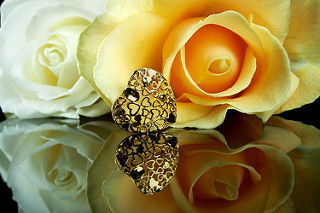

Image (CC BY 2.0)  by hmomoy



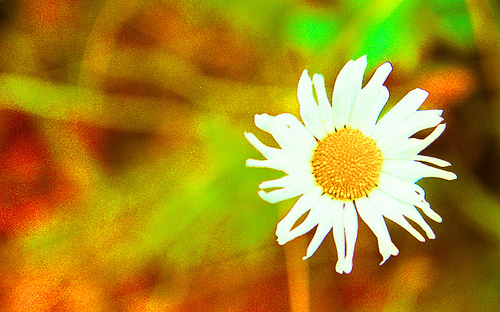

Image (CC BY 2.0)  by Sarah Joy



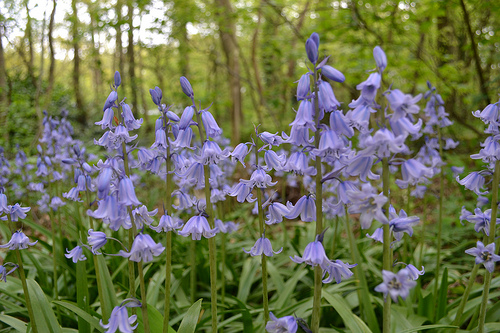

Image (CC BY 2.0)  by Olga



In [29]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

确定每张图片的标签

In [30]:
label_names = sorted(item.name for item in data_root.glob("*/") if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [32]:
# 为每个标签分配索引

label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [33]:
# 创建一个列表，包含每个文件的标签索引

all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                   for path in all_image_paths]

print("First 10 labels indices:", all_image_labels[:10])

First 10 labels indices: [3, 1, 4, 2, 3, 3, 4, 0, 4, 3]


加载和格式化图片

In [34]:
img_path = all_image_paths[0]
img_path

'G:\\桌面\\flower_photos\\sunflowers\\2895404754_6d9f9416d7_n.jpg'

In [35]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [36]:
# 将其解码为图像tensor

img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(213, 320, 3)
<dtype: 'uint8'>


In [39]:
# 根据模型调整大小

img_final = tf.image.resize(img_tensor, [192, 192])
img_final = img_final / 255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
1.0


In [40]:
# 包装成函数，以备后用

def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192, 192])
    image /= 255.0 #Normalize to [0-1] range
    return image

In [41]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

Text(0.5, 1.0, 'Sunflowers')

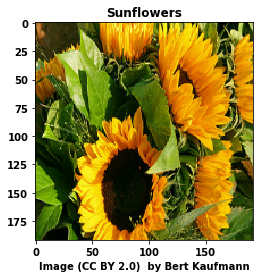

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())

② 构建tf.data.Dataset

In [49]:
# 一个图片数据集

构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。  
将字符串数组切片，得到一个字符串数据集：

In [45]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

shapes（维数） 和 types（类型） 描述数据集里每个数据项的内容。在这里是一组标量二进制字符串。

In [46]:
print(path_ds)

<TensorSliceDataset shapes: (), types: tf.string>


现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。

In [47]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

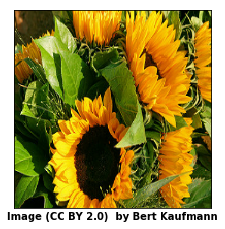

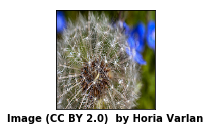

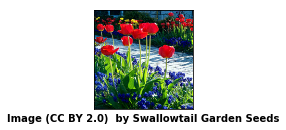

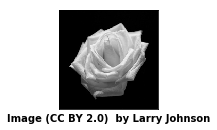

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2, n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()

③ 一个(图片, 标签)对数据集

使用同样的 from_tensor_slices 方法你可以创建一个标签数据集：

In [53]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [54]:
for label in labels_ds.take(10):
    print(label_names[label.numpy()])

sunflowers
dandelion
tulips
roses
sunflowers
sunflowers
tulips
daisy
tulips
sunflowers


由于这些数据集顺序相同，你可以将他们打包在一起得到一个(图片, 标签)对数据集：

In [55]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

这个新数据集的 shapes（维数） 和 types（类型） 也是维数和类型的元组，用来描述每个字段：

In [56]:
print(image_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


注意：当你拥有形似 all_image_labels 和 all_image_paths 的数组，tf.data.dataset.Dataset.zip 的替代方法是将这对数组切片。

In [58]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

③ 训练方法

要使用此数据集训练模型，你将会想要数据：

+ 被充分打乱。
+ 被分割为 batch。
+ 永远重复。
+ 尽快提供 batch。

In [59]:
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小） 以保证数据被充分打乱
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练时， “prefetch”使数据集在后台取得batch
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

这里有一些注意事项：

+ 顺序很重要。
    在 .repeat 之后 .shuffle，会在 epoch 之间打乱数据（当有些数据出现两次的时候，其他数据还没有出现过）。
    在 .batch 之后 .shuffle，会打乱 batch 的顺序，但是不会在 batch 之间打乱数据。

+ 你在完全打乱中使用和数据集大小一样的 buffer_size（缓冲区大小）。较大的缓冲区大小提供更好的随机化，但使用更多的内存，直到超过数据集大小。

+ 在从随机缓冲区中拉取任何元素前，要先填满它。所以当你的 Dataset（数据集）启动的时候一个大的 buffer_size（缓冲区大小）可能会引起延迟。

+ 在随机缓冲区完全为空之前，被打乱的数据集不会报告数据集的结尾。Dataset（数据集）由 .repeat 重新启动，导致需要再次等待随机缓冲区被填满。

可以通过使用 tf.data.Dataset.apply 方法和融合过的 tf.data.experimental.shuffle_and_repeat 函数来解决:

In [61]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count)
)
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

W0616 14:18:39.320945  7764 deprecation.py:323] From <ipython-input-61-cdc25c469325>:2: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

④ 传递数据集至模型

从 tf.keras.applications 取得 MobileNet v2 副本。
该模型副本会被用于一个简单的迁移学习例子。

设置 MobileNet 的权重为不可训练：

In [65]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable = False

Exception: URL fetch failure on https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/download/v1.1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5: None -- [WinError 10060] 由于连接方在一段时间后没有正确答复或连接的主机没有反应，连接尝试失败。

#### 文本

使用 tf.data.TextLineDataset 来加载文本文件  
TextLineDataset 通常被用来以文本文件构建数据集（原文件中的一行为一个样本)   
这适用于大多数的基于行的文本数据（例如，诗歌或错误日志)   

In [129]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import tensorflow_datasets as tfds
import os

使用的文本文件已经进行过一些典型的预处理，主要包括删除了文档页眉和页脚，行号，章节标题

In [130]:
DIRECTORY_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
FILE_NAMES = ["cowper.txt", "derby.txt", "butler.txt"]

for name in FILE_NAMES:
    text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_URL + name)
parent_dir = os.path.dirname(text_dir)

① 将文本加载到数据集中

迭代整个文件，将整个文件加载到自己的数据集中。  
每个样本都需要单独标记，所以请使用 tf.data.Dataset.map 来为每个样本设定标签。这将迭代数据集中的每一个样本并且返回（ example, label ）对。

In [131]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [132]:
# 将这些标记数据集合并到一个数据集中，然后对其进行随机化操作

BUFFER_SIZE = 50000
BATCH_SIZE = 64
TAKE_SIZE = 5000

In [133]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
            BUFFER_SIZE, reshuffle_each_iteration=False)

你可以使用 tf.data.Dataset.take 与 print 来查看 (example, label) 对的外观。numpy 属性显示每个 Tensor 的值。

In [134]:
for ex in all_labeled_data.take(5):
    print(ex)

(<tf.Tensor: shape=(), dtype=string, numpy=b'He who the blow had dealt, and with his spear'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'it--there is then toil for all, and sorrow for not a few--even so did'>, <tf.Tensor: shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Son of Eetion, rich, of blameless life,'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'And bade his comrades lead them to the ships.'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'Of rage less fiercely burning in my breast;'>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


② 将文本编码成数字

机器学习基于的是数字而非文本，所以字符串需要被转化成数字列表

1. 建立词汇表

首先，通过将文本标记为单独的单词集合来构建词汇表：
+ 迭代每个样本的 numpy 值。
+ 使用 tfds.features.text.Tokenizer 来将其分割成 token。
+ 将这些 token 放入一个 Python 集合中，借此来清除重复项。
+ 获取该词汇表的大小以便于以后使用。

In [135]:
tokenizer = tfds.features.text.Tokenizer()

vocabulary_set = set()
for text_tensor, _ in all_labeled_data:
    some_tokens = tokenizer.tokenize(text_tensor.numpy())
    vocabulary_set.update(some_tokens)

vocab_size = len(vocabulary_set)
vocab_size

17178

2. 样本编码

通过传递 vocabulary_set 到 tfds.features.text.TokenTextEncoder 来构建一个编码器。编码器的 encode 方法传入一行文本，返回一个整数列表。

In [136]:
encoder = tfds.features.text.TokenTextEncoder(vocabulary_set)

In [137]:
example_text = next(iter(all_labeled_data))[0].numpy()
print(example_text)

b'He who the blow had dealt, and with his spear'


In [138]:
encoded_example = encoder.encode(example_text)
print(encoded_example)

[8286, 15244, 3581, 9399, 5767, 7298, 14362, 14402, 14251, 15727]


现在，在数据集上运行编码器（通过将编码器打包到 tf.py_function 并且传参至数据集的 map 方法的方式来运行）。

In [139]:
def encode(text_tensor, label):
    encoded_text = encoder.encode(text_tensor.numpy())
    return encoded_text, label

def encode_map_fn(text, label):
    # py_func doesn't set the shape of the returned tensors.
    encoded_text, label = tf.py_function(encode, 
                                       inp=[text, label], 
                                       Tout=(tf.int64, tf.int64))

    # `tf.data.Datasets` work best if all components have a shape set
    #  so set the shapes manually: 
    encoded_text.set_shape([None])
    label.set_shape([])

    return encoded_text, label


all_encoded_data = all_labeled_data.map(encode_map_fn)
for text, label in all_encoded_data.take(5):
    print(text, label)

tf.Tensor([ 8286 15244  3581  9399  5767  7298 14362 14402 14251 15727], shape=(10,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(
[10980 12919  1586 10325  7836 14853  1750 14362 16981 14853 12412  9104
  3013 17019  4644  8897], shape=(16,), dtype=int64) tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor([  253  7065  7900  3317  7065  3578 13600], shape=(7,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([ 1113  9340 14251 16601  4542 15466 13556  3581 12376], shape=(9,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor([ 3445 12083 14843   656  2668  8161  2303  2987], shape=(8,), dtype=int64) tf.Tensor(1, shape=(), dtype=int64)


③ 将数据集分割为测试集和训练集且进行分支

使用 tf.data.Dataset.take 和 tf.data.Dataset.skip 来建立一个小一些的测试数据集和稍大一些的训练数据集。  

在数据集被传入模型之前，数据集需要被分批。最典型的是，每个分支中的样本大小与格式需要一致。但是数据集中样本并不全是相同大小的（每行文本字数并不相同）。因此，使用 tf.data.Dataset.padded_batch（而不是 batch ）将样本填充到相同的大小。

In [140]:
train_data = all_encoded_data.skip(TAKE_SIZE).shuffle(BUFFER_SIZE)
train_data = train_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

test_data = all_encoded_data.take(TAKE_SIZE)
test_data = test_data.padded_batch(BATCH_SIZE, padded_shapes=([None], []))

现在，test_data 和 train_data 不是（ example, label ）对的集合，而是批次的集合。每个批次都是一对（多样本, 多标签 ），表示为数组。

In [141]:
sample_text, sample_labels = next(iter(test_data))
print(len(sample_text))
sample_text[0], sample_labels[0]

64


(<tf.Tensor: shape=(16,), dtype=int64, numpy=
 array([ 8286, 15244,  3581,  9399,  5767,  7298, 14362, 14402, 14251,
        15727,     0,     0,     0,     0,     0,     0], dtype=int64)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

由于我们引入了一个新的 token 来编码（填充零），因此词汇表大小增加了一个。

In [142]:
vocab_size += 1

④ 建立模型

In [143]:
model = tf.keras.Sequential()

In [144]:
# 第一层将整数表示转换为密集矢量嵌入
model.add(tf.keras.layers.Embedding(vocab_size, 64))

In [145]:
# 下一层是 LSTM 层，它允许模型利用上下文中理解单词含义。 LSTM 上的双向包装器有助于模型理解当前数据点与其之前和之后的数据点的关系。
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))

In [146]:
# 最后，我们将获得一个或多个紧密连接的层，其中最后一层是输出层。输出层输出样本属于各个标签的概率，最后具有最高概率的分类标签即为最终预测结果。

# 一个或多个紧密连接的层
# 编辑 “for”行的列表去检测层的大小
for units in [64, 64]:
    model.add(tf.keras.layers.Dense(units, activation="relu"))
    
# 输出层，第一个参数是标签个数
model.add(tf.keras.layers.Dense(3, activation="softmax"))

In [147]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

⑤ 训练模型

In [148]:
model.fit(train_data, epochs=3, validation_data = test_data)

Epoch 1/3


    168/Unknown - 8s 8s/step - loss: 1.0991 - accuracy: 0.26 - 8s 4s/step - loss: 1.0969 - accuracy: 0.35 - 8s 3s/step - loss: 1.0962 - accuracy: 0.34 - 8s 2s/step - loss: 1.0948 - accuracy: 0.37 - 8s 2s/step - loss: 1.0922 - accuracy: 0.37 - 9s 1s/step - loss: 1.0899 - accuracy: 0.37 - 9s 1s/step - loss: 1.0875 - accuracy: 0.38 - 9s 1s/step - loss: 1.0859 - accuracy: 0.38 - 9s 959ms/step - loss: 1.0826 - accuracy: 0.390 - 9s 867ms/step - loss: 1.0834 - accuracy: 0.375 - 9s 791ms/step - loss: 1.0811 - accuracy: 0.373 - 9s 729ms/step - loss: 1.0774 - accuracy: 0.380 - 9s 676ms/step - loss: 1.0752 - accuracy: 0.373 - 9s 630ms/step - loss: 1.0711 - accuracy: 0.373 - 9s 590ms/step - loss: 1.0675 - accuracy: 0.377 - 9s 556ms/step - loss: 1.0673 - accuracy: 0.377 - 9s 526ms/step - loss: 1.0639 - accuracy: 0.375 - 9s 499ms/step - loss: 1.0574 - accuracy: 0.379 - 9s 475ms/step - loss: 1.0512 - accuracy: 0.380 - 9s 453ms/step - loss: 1.0463 - accuracy: 0.380 - 9s 433ms/step - loss: 1.0372 - acc

    335/Unknown - 16s 93ms/step - loss: 0.7037 - accuracy: 0.619 - 16s 93ms/step - loss: 0.7028 - accuracy: 0.620 - 16s 93ms/step - loss: 0.7023 - accuracy: 0.620 - 16s 93ms/step - loss: 0.7010 - accuracy: 0.621 - 16s 93ms/step - loss: 0.7002 - accuracy: 0.622 - 16s 92ms/step - loss: 0.6996 - accuracy: 0.622 - 16s 92ms/step - loss: 0.6987 - accuracy: 0.622 - 16s 92ms/step - loss: 0.6983 - accuracy: 0.622 - 16s 91ms/step - loss: 0.6973 - accuracy: 0.623 - 16s 91ms/step - loss: 0.6962 - accuracy: 0.624 - 16s 91ms/step - loss: 0.6948 - accuracy: 0.625 - 16s 91ms/step - loss: 0.6939 - accuracy: 0.625 - 16s 90ms/step - loss: 0.6933 - accuracy: 0.625 - 16s 90ms/step - loss: 0.6930 - accuracy: 0.625 - 16s 90ms/step - loss: 0.6931 - accuracy: 0.625 - 17s 90ms/step - loss: 0.6929 - accuracy: 0.626 - 17s 89ms/step - loss: 0.6929 - accuracy: 0.625 - 17s 89ms/step - loss: 0.6918 - accuracy: 0.626 - 17s 89ms/step - loss: 0.6912 - accuracy: 0.626 - 17s 89ms/step - loss: 0.6912 - accuracy: 0.627 - 17

    502/Unknown - 23s 67ms/step - loss: 0.6187 - accuracy: 0.680 - 23s 67ms/step - loss: 0.6183 - accuracy: 0.680 - 23s 67ms/step - loss: 0.6182 - accuracy: 0.681 - 23s 67ms/step - loss: 0.6186 - accuracy: 0.681 - 23s 67ms/step - loss: 0.6181 - accuracy: 0.681 - 23s 67ms/step - loss: 0.6176 - accuracy: 0.681 - 23s 67ms/step - loss: 0.6174 - accuracy: 0.682 - 23s 67ms/step - loss: 0.6171 - accuracy: 0.682 - 23s 67ms/step - loss: 0.6169 - accuracy: 0.682 - 23s 66ms/step - loss: 0.6167 - accuracy: 0.682 - 23s 66ms/step - loss: 0.6162 - accuracy: 0.682 - 23s 66ms/step - loss: 0.6159 - accuracy: 0.682 - 23s 66ms/step - loss: 0.6154 - accuracy: 0.683 - 23s 66ms/step - loss: 0.6151 - accuracy: 0.683 - 23s 66ms/step - loss: 0.6148 - accuracy: 0.683 - 23s 66ms/step - loss: 0.6145 - accuracy: 0.684 - 23s 66ms/step - loss: 0.6139 - accuracy: 0.684 - 23s 66ms/step - loss: 0.6134 - accuracy: 0.684 - 23s 66ms/step - loss: 0.6132 - accuracy: 0.684 - 23s 66ms/step - loss: 0.6131 - accuracy: 0.685 - 23

    669/Unknown - 29s 58ms/step - loss: 0.5676 - accuracy: 0.718 - 29s 58ms/step - loss: 0.5674 - accuracy: 0.718 - 29s 58ms/step - loss: 0.5671 - accuracy: 0.719 - 29s 58ms/step - loss: 0.5669 - accuracy: 0.719 - 29s 58ms/step - loss: 0.5666 - accuracy: 0.719 - 29s 58ms/step - loss: 0.5661 - accuracy: 0.719 - 29s 58ms/step - loss: 0.5659 - accuracy: 0.719 - 29s 58ms/step - loss: 0.5655 - accuracy: 0.719 - 30s 58ms/step - loss: 0.5649 - accuracy: 0.720 - 30s 58ms/step - loss: 0.5645 - accuracy: 0.720 - 30s 58ms/step - loss: 0.5642 - accuracy: 0.720 - 30s 58ms/step - loss: 0.5638 - accuracy: 0.720 - 30s 58ms/step - loss: 0.5634 - accuracy: 0.720 - 30s 58ms/step - loss: 0.5632 - accuracy: 0.721 - 30s 58ms/step - loss: 0.5626 - accuracy: 0.721 - 30s 58ms/step - loss: 0.5621 - accuracy: 0.721 - 30s 58ms/step - loss: 0.5618 - accuracy: 0.721 - 30s 57ms/step - loss: 0.5614 - accuracy: 0.722 - 30s 57ms/step - loss: 0.5610 - accuracy: 0.722 - 30s 57ms/step - loss: 0.5606 - accuracy: 0.722 - 30

697/697 [==============================]0.5300 - accuracy: 0.740 - 36s 54ms/step - loss: 0.5298 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5296 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5295 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5294 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5291 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5289 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5287 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5286 - accuracy: 0.741 - 36s 54ms/step - loss: 0.5284 - accuracy: 0.741 - 36s 53ms/step - loss: 0.5284 - accuracy: 0.741 - 36s 53ms/step - loss: 0.5282 - accuracy: 0.741 - 36s 53ms/step - loss: 0.5279 - accuracy: 0.742 - 36s 53ms/step - loss: 0.5277 - accuracy: 0.742 - 37s 53ms/step - loss: 0.5276 - accuracy: 0.742 - 37s 53ms/step - loss: 0.5274 - accuracy: 0.742 - 37s 53ms/step - loss: 0.5272 - accuracy: 0.742 - 37s 53ms/step - loss: 0.5271 - accuracy: 0.742 - 37s 53ms/step - loss: 0.5267 - accuracy: 0.742 - 37s 53ms/step - loss: 0.5266 - accuracy: 0.742 - 37

358/697 [==============>...............] - ETA: 1:17:30 - loss: 0.3118 - accuracy: 0.890 - ETA: 26:00 - loss: 0.3079 - accuracy: 0.8906  - ETA: 15:44 - loss: 0.2892 - accuracy: 0.900 - ETA: 11:19 - loss: 0.2915 - accuracy: 0.886 - ETA: 8:52 - loss: 0.3085 - accuracy: 0.880 - ETA: 7:18 - loss: 0.3048 - accuracy: 0.87 - ETA: 6:14 - loss: 0.3103 - accuracy: 0.87 - ETA: 5:49 - loss: 0.3126 - accuracy: 0.87 - ETA: 5:08 - loss: 0.3152 - accuracy: 0.87 - ETA: 4:36 - loss: 0.3075 - accuracy: 0.87 - ETA: 4:10 - loss: 0.3161 - accuracy: 0.87 - ETA: 3:49 - loss: 0.3032 - accuracy: 0.87 - ETA: 3:31 - loss: 0.3008 - accuracy: 0.87 - ETA: 3:16 - loss: 0.2990 - accuracy: 0.87 - ETA: 3:03 - loss: 0.2971 - accuracy: 0.87 - ETA: 2:52 - loss: 0.2915 - accuracy: 0.87 - ETA: 2:43 - loss: 0.2867 - accuracy: 0.87 - ETA: 2:34 - loss: 0.2820 - accuracy: 0.88 - ETA: 2:26 - loss: 0.2823 - accuracy: 0.88 - ETA: 2:20 - loss: 0.2854 - accuracy: 0.87 - ETA: 2:13 - loss: 0.2864 - accuracy: 0.87 - ETA: 2:08 - loss: 0.

697/697 [==============================] - ETA: 18s - loss: 0.3007 - accuracy: 0.869 - ETA: 18s - loss: 0.3003 - accuracy: 0.869 - ETA: 18s - loss: 0.3007 - accuracy: 0.869 - ETA: 18s - loss: 0.3014 - accuracy: 0.868 - ETA: 18s - loss: 0.3014 - accuracy: 0.868 - ETA: 18s - loss: 0.3015 - accuracy: 0.868 - ETA: 17s - loss: 0.3016 - accuracy: 0.868 - ETA: 17s - loss: 0.3019 - accuracy: 0.868 - ETA: 17s - loss: 0.3020 - accuracy: 0.868 - ETA: 17s - loss: 0.3017 - accuracy: 0.868 - ETA: 17s - loss: 0.3019 - accuracy: 0.868 - ETA: 17s - loss: 0.3015 - accuracy: 0.868 - ETA: 17s - loss: 0.3016 - accuracy: 0.868 - ETA: 17s - loss: 0.3019 - accuracy: 0.868 - ETA: 16s - loss: 0.3017 - accuracy: 0.868 - ETA: 16s - loss: 0.3013 - accuracy: 0.868 - ETA: 16s - loss: 0.3013 - accuracy: 0.868 - ETA: 16s - loss: 0.3010 - accuracy: 0.868 - ETA: 16s - loss: 0.3007 - accuracy: 0.868 - ETA: 16s - loss: 0.3005 - accuracy: 0.868 - ETA: 16s - loss: 0.3005 - accuracy: 0.868 - ETA: 16s - loss: 0.2999 - accurac

359/697 [==============>...............] - ETA: 1:15:38 - loss: 0.3892 - accuracy: 0.796 - ETA: 25:23 - loss: 0.3333 - accuracy: 0.8594  - ETA: 15:21 - loss: 0.2699 - accuracy: 0.881 - ETA: 11:04 - loss: 0.2446 - accuracy: 0.897 - ETA: 8:39 - loss: 0.2432 - accuracy: 0.895 - ETA: 7:09 - loss: 0.2282 - accuracy: 0.90 - ETA: 6:05 - loss: 0.2281 - accuracy: 0.90 - ETA: 5:19 - loss: 0.2202 - accuracy: 0.90 - ETA: 4:43 - loss: 0.2253 - accuracy: 0.90 - ETA: 4:15 - loss: 0.2267 - accuracy: 0.90 - ETA: 3:53 - loss: 0.2236 - accuracy: 0.90 - ETA: 3:33 - loss: 0.2258 - accuracy: 0.90 - ETA: 3:18 - loss: 0.2263 - accuracy: 0.90 - ETA: 3:04 - loss: 0.2251 - accuracy: 0.90 - ETA: 2:52 - loss: 0.2301 - accuracy: 0.90 - ETA: 2:42 - loss: 0.2316 - accuracy: 0.90 - ETA: 2:33 - loss: 0.2310 - accuracy: 0.89 - ETA: 2:25 - loss: 0.2295 - accuracy: 0.90 - ETA: 2:18 - loss: 0.2296 - accuracy: 0.90 - ETA: 2:11 - loss: 0.2264 - accuracy: 0.90 - ETA: 2:05 - loss: 0.2242 - accuracy: 0.90 - ETA: 2:00 - loss: 0.

697/697 [==============================] - ETA: 18s - loss: 0.2176 - accuracy: 0.906 - ETA: 18s - loss: 0.2173 - accuracy: 0.906 - ETA: 17s - loss: 0.2176 - accuracy: 0.906 - ETA: 17s - loss: 0.2174 - accuracy: 0.906 - ETA: 17s - loss: 0.2173 - accuracy: 0.906 - ETA: 17s - loss: 0.2175 - accuracy: 0.906 - ETA: 17s - loss: 0.2175 - accuracy: 0.906 - ETA: 17s - loss: 0.2178 - accuracy: 0.906 - ETA: 17s - loss: 0.2182 - accuracy: 0.906 - ETA: 17s - loss: 0.2185 - accuracy: 0.906 - ETA: 16s - loss: 0.2188 - accuracy: 0.905 - ETA: 16s - loss: 0.2191 - accuracy: 0.905 - ETA: 16s - loss: 0.2193 - accuracy: 0.905 - ETA: 16s - loss: 0.2198 - accuracy: 0.905 - ETA: 16s - loss: 0.2198 - accuracy: 0.905 - ETA: 16s - loss: 0.2201 - accuracy: 0.905 - ETA: 16s - loss: 0.2198 - accuracy: 0.905 - ETA: 16s - loss: 0.2204 - accuracy: 0.905 - ETA: 15s - loss: 0.2208 - accuracy: 0.905 - ETA: 15s - loss: 0.2210 - accuracy: 0.904 - ETA: 15s - loss: 0.2209 - accuracy: 0.904 - ETA: 15s - loss: 0.2212 - accurac

In [151]:
eval_loss, eval_acc = model.evaluate(test_data)

print("\nEval loss: {}, Eval acc: {}".format(eval_loss, eval_acc))

     79/Unknown - 1s 729ms/step - loss: 0.2699 - accuracy: 0.921 - 1s 374ms/step - loss: 0.3169 - accuracy: 0.882 - 1s 256ms/step - loss: 0.3212 - accuracy: 0.885 - 1s 197ms/step - loss: 0.3174 - accuracy: 0.875 - 1s 162ms/step - loss: 0.3215 - accuracy: 0.868 - 1s 137ms/step - loss: 0.3245 - accuracy: 0.867 - 1s 121ms/step - loss: 0.3338 - accuracy: 0.870 - 1s 109ms/step - loss: 0.3467 - accuracy: 0.861 - 1s 99ms/step - loss: 0.3652 - accuracy: 0.852 - 1s 91ms/step - loss: 0.3579 - accuracy: 0.85 - 1s 84ms/step - loss: 0.3597 - accuracy: 0.84 - 1s 79ms/step - loss: 0.3575 - accuracy: 0.84 - 1s 75ms/step - loss: 0.3704 - accuracy: 0.84 - 1s 71ms/step - loss: 0.3608 - accuracy: 0.84 - 1s 68ms/step - loss: 0.3592 - accuracy: 0.84 - 1s 65ms/step - loss: 0.3598 - accuracy: 0.84 - 1s 62ms/step - loss: 0.3604 - accuracy: 0.84 - 1s 60ms/step - loss: 0.3657 - accuracy: 0.83 - 1s 58ms/step - loss: 0.3640 - accuracy: 0.83 - 1s 56ms/step - loss: 0.3634 - accuracy: 0.83 - 1s 54ms/step - loss: 0.36